# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 48kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

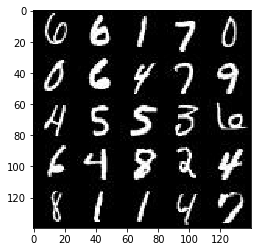

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

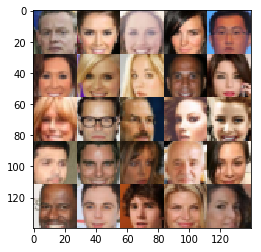

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="real_input")
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="z_input")
    learn_rate = tf.placeholder(dtype=tf.float32, shape=(), name="learn_rate")

    return (real_input, z_input, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # AE: Assuming that we'll be passing in data through the "real_input" placeholder created in the "model_inputs" above.
    # AE: In that case "images" will have this shape: shape=(None, image_width, image_height, image_channels).
    # AE: We know that both image_width=28 and image_height=28
    
    # AE: We'll be using drop out layers as per suggestion in the review. We need to define drop out rate
    dropout_rate = 0.33
    kernel_size = (8, 8)
    stride = (2, 2)
    
    with tf.variable_scope('discriminator', reuse=reuse):    
        # AE: Let's try a convolution layer with 32 filters to start with, kernel of 3x3, strides=2x2 and ReLU activation 
        # AE: function. Image is now 28x28x3 and we'll convert it to 14x14x32
        # AE: As per suggestion in the review, we'll use Xavier weights initialiser.
        c1 = tf.contrib.layers.conv2d(inputs=images, num_outputs=32, kernel_size=kernel_size, stride=stride, padding='SAME', 
                                      activation_fn=None, weights_initializer=tf.contrib.layers.xavier_initializer())

        # AE: Don't apply batch normalisation on the first convolutional layer in discriminator, they said.
        #c1 = tf.layers.batch_normalization(inputs=c1, momentum=0.99, epsilon=0.001, training=True)

        # AE: Applying leaky relu
        c1 = tf.maximum(c1 * alpha, c1)

        # AE: Input is now 14x14x32 and we'll convert it to 7x7x64
        # AE: As per suggestion in the review, we'll use Xavier weights initialiser.
        c2 = tf.contrib.layers.conv2d(inputs=c1, num_outputs=64, kernel_size=kernel_size, stride=stride, padding='SAME', 
                                      activation_fn=None, weights_initializer=tf.contrib.layers.xavier_initializer()) # activation_fn=tf.nn.relu
        c2 = tf.layers.batch_normalization(inputs=c2, momentum=0.99, epsilon=0.001, training=True)
        
        # AE: Adding a drop out layer to improve the strength of the network as per suggestions in the review-
        # AE after batch normalisation, but before activation function.
        c2 = tf.layers.dropout(inputs=c2, rate=dropout_rate)
        
        # AE: Applying leaky relu
        c2 = tf.maximum(c2 * alpha, c2)
        
        #print("C2 shape: ", c2.get_shape())
        
        # AE: Input is now 7x7x64 and we'll convert it to 3x3x128
        # AE: We'll be using padding='VALID' here to drop the remaining pixel when we want to downscale 7x7 image into
        # AE: a 3x3 one. That way the kernel window will ignore the last row and last column, instead of adding an extra
        # AE: one with a copy of the previous row and column.
        # AE:
        # AE: Actually, what I described above was a bad idea. It's better to have padding='SAME' and 
        # AE: use all information in the tensor. Later we'll reshape it to 4x4x128 instead of 3x3x128 and
        # AE: we'll get better results.
        # AE: As per suggestion in the review, we'll use Xavier weights initialiser.
        c3 = tf.contrib.layers.conv2d(inputs=c2, num_outputs=128, kernel_size=kernel_size, stride=stride, padding='SAME', 
                                      activation_fn=None, weights_initializer=tf.contrib.layers.xavier_initializer()) # activation_fn=tf.nn.relu
        c3 = tf.layers.batch_normalization(inputs=c3, momentum=0.99, epsilon=0.001, training=True)
        
        # AE: Adding a drop out layer to improve the strength of the network as per suggestions in the review-
        # AE after batch normalisation, but before activation function.
        c3 = tf.layers.dropout(inputs=c3, rate=dropout_rate)
        
        # AE: Applying leaky relu
        c3 = tf.maximum(c3 * alpha, c3)
        
        #print("C3 shape: ", c3.get_shape())
        
        # AE: Now let's flatten it and get a single result through a dense layer:
        c3 = tf.reshape(c3, (-1, 4 * 4 * 128))
        logits = tf.layers.dense(inputs=c3, units=1, activation=None, use_bias=True)
        
        output = tf.sigmoid(logits)
        
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    # AE: We'll be using drop out layers as per suggestion in the review. We need to define drop out rate
    dropout_rate = 0.33
    
    kernel_size = (8, 8)
    stride = (2, 2)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # AE: Let's start with a dense layer where we'll load in z and stretch it to a starting shape of 2x2x512
        fc = tf.layers.dense(inputs=z, units=512 * 2 * 2, activation=None, use_bias=True)

        # AE: Now turn it into the correct shape
        fc = tf.reshape(fc, [-1, 2, 2, 512])
        # AE: Now batch normalisation
        fcbn = tf.layers.batch_normalization(inputs=fc, momentum=0.99, epsilon=0.001, training=is_train)
        # AE: Leaky ReLU
        fcbnlr = tf.maximum(fcbn * alpha, fcbn)
        #print(fcbnlr.shape)

        # AE: And off we go with the convolutional transpose layers to downscale number of filters and make our picture emerge
        # AE: Our random values are now shaped: 2x2x512. Let's get them into 4x4x256
        # AE: As per suggestion in the review, we'll use Xavier weights initialiser.
        ct1 = tf.contrib.layers.conv2d_transpose(inputs=fcbnlr, num_outputs=256, kernel_size=kernel_size, stride=stride, 
                                                 padding='SAME', activation_fn=None, 
                                                 weights_initializer=tf.contrib.layers.xavier_initializer()) #data_format=DATA_FORMAT_NHWC, activation_fn=tf.nn.relu,
        #activation_fn=tf.nn.relu, weights_initializer=tf.contrib.layers.xavier_initializer()        
        # AE: Batch normalisation
        ct1bn = tf.layers.batch_normalization(inputs=ct1, momentum=0.99, epsilon=0.001, training=is_train)
        
        # AE: Adding a drop out layer to improve the strength of the network as per suggestions in the review-
        # AE after batch normalisation, but before activation function.
        ct1bn = tf.layers.dropout(inputs=ct1bn, rate=dropout_rate)
        
        # AE: Leaky ReLU
        ct1bnlr = tf.maximum(ct1bn * alpha, ct1bn)
        
        #print(ct1bnlr.shape)
        
        # AE: 4x4x256 -> 8x8x128
        ct2 = tf.contrib.layers.conv2d_transpose(inputs=ct1bnlr, num_outputs=128, kernel_size=kernel_size, stride=stride, 
                                                 padding='SAME', activation_fn=None, 
                                                 weights_initializer=tf.contrib.layers.xavier_initializer())
        #ct2 = tf.layers.dropout(inputs=ct2, rate=0.3)
        ct2bn = tf.layers.batch_normalization(inputs=ct2, momentum=0.99, epsilon=0.001, training=is_train)
        
        # AE: Adding a drop out layer to improve the strength of the network as per suggestions in the review-
        # AE after batch normalisation, but before activation function.
        ct2bn = tf.layers.dropout(inputs=ct2bn, rate=dropout_rate)
        
        ct2bnlr = tf.maximum(ct2bn * alpha, ct2bn)
        
        #print(ct2bnlr.shape)

        # AE: 8x8x128 -> 16x16x64
        ct3 = tf.contrib.layers.conv2d_transpose(inputs=ct2bnlr, num_outputs=64, kernel_size=kernel_size, stride=stride, 
                                                 padding='SAME', activation_fn=None, 
                                                 weights_initializer=tf.contrib.layers.xavier_initializer())
        #ct3 = tf.layers.dropout(inputs=ct3, rate=0.3)
        ct3bn = tf.layers.batch_normalization(inputs=ct3, momentum=0.99, epsilon=0.001, training=is_train)
        
        # AE: Adding a drop out layer to improve the strength of the network as per suggestions in the review-
        # AE after batch normalisation, but before activation function.
        ct3bn = tf.layers.dropout(inputs=ct3bn, rate=dropout_rate)
        
        ct3bnlr = tf.maximum(ct3bn * alpha, ct3bn)
        
        #print(ct3bnlr.shape)

        # AE: 16x16x128 -> 32x32x3 (or 32x32x1 in case of MNIST)
        ct4 = tf.contrib.layers.conv2d_transpose(inputs=ct3bnlr, num_outputs=out_channel_dim, kernel_size=kernel_size, stride=stride, 
                                                 padding='SAME', activation_fn=None, 
                                                 weights_initializer=tf.contrib.layers.xavier_initializer())
        
        # AE: now we have 32x32x3 shape, but we want 28x28x3. We could flatten, then drop values from the tail, then 
        # AE: reshape back, but that would brutally change the content of the dimensions. Maybe instead we could 
        # AE: carefully carve out what we want through slicing. And of course we want tanh activation.
        output = ct4[:, :28, :28, :]
        output = tf.tanh(output)
        
        #output_flattened = tf.flatten(output)
        #print(output.shape, " out_channel_dim=", out_channel_dim)
        
        #print("0: ", output[0][0][0].shape, "1: ", output[1].shape, "2: ", output[2].shape, "3: ", output[3].shape)
        #print("0: ", output[28:][28:][0])
        #print("0ut: ", output[:, :28, :28, :])
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # AE: In essence we want to create a generator and discriminator, then feed the input_z to the generator,
    # AE: then feed generator's output to the discriminator, then the output of the disciminator (assuming 1 means
    # AE: natural picture and 0-artificial) is discriminator's loss. Generator's loss is discriminator's output 
    # AE: subtracted from 1. Discriminator should also be tested against the real image and its result subtracted from
    # AE: 1. That will be discrimantor's loss for real images. Both discriminator's losses need to be summed to take both 
    # AE: of them into account (should they be aggregated?).
    # AE:
    # AE: Also, for discriminator, we don't want to give it the labels of 1 for real pictures. We will allow it to
    # AE: generalise better (and make the whole discriminator a little weaker, which allows better generator learning)
    # AE: by "smoothing" out the labels. In essence we need to remove a small value from the label of "1" for real pictures.
    # AE:
    # AE: We want generator to NOT re-use the variables, because ... not sure?? ... so setting is_train=True.
    
    smoothing_factor = 0.1
    
    g = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    # AE: The first discriminator should NOT re-use variables, because they have not been set up yet.
    d_artificial, d_a_logits = discriminator(g, reuse=False, alpha=alpha)
    # AE: The second discriminator SHOULD re-use variables from the first discriminator 
    d_real, d_r_logits = discriminator(input_real, reuse=True, alpha=alpha)
    

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_a_logits, labels=tf.zeros_like(d_artificial)))
    
    # AE: as suggested in review, we'll smooth generator's labels for fake pictures.
    g_labels = tf.ones_like(d_artificial) * (1 - smoothing_factor)
    
    # AE: Discriminator gave us an answer (something like 0.2 which means 20% yes and 80% no), we want to compare that answer
    # AE: to YES (0% no and 100% yes), because the more mistakes discriminator made (saying YES here), the smaller the loss
    # AE: will be for generator, which actually generated this fake image.
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_a_logits, labels=g_labels))
    
    # AE: as suggested in review, we'll smooth discriminator's labels for real pictures.
    d_real_labels = tf.ones_like(d_real) * (1 - smoothing_factor)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_r_logits, labels=d_real_labels))

    d_loss = d_loss_real + d_loss_fake

    #g_loss = 1 - d_a_logits
    #d_loss = d_a_logits + (1 - d_r_logits)
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # AE: Let's use Adam optimiser on the loss that we calculated earlier and let the optimiser change the variables
    # AE: that we get from tf.trainable_variables
    all_vars = tf.trainable_variables()
    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in all_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    return (d_opt, g_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
# AE: To implement train method, I need to know for sure how the datasets look like.

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print("MNIST shape and mode: ", mnist_dataset.shape, mnist_dataset.image_mode)

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print("CELEBA shape and mode: ", celeba_dataset.shape, celeba_dataset.image_mode)

MNIST shape and mode:  (60000, 28, 28, 1) L
CELEBA shape and mode:  (202599, 28, 28, 3) RGB


In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    img_width = data_shape[1]
    img_height = data_shape[2]
    out_channel_dim = data_shape[3]

    # AE: placeholders, which we'll change when training (feed into the TF session)
    real_input, z_input, learn_rate = model_inputs(img_width, img_height, out_channel_dim, z_dim)

    # AE: And now the model taking in the placeholders
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim, alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    # AE: number of batches pushed through our model
    batches_pushed = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # AE: We have a batch of real images in the batch_images, but we also need a batch of random vectors
                # AE: to give to the generator. Both batches of course need to be the same size.
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # AE: Now we can run generator and discriminator in the TF session, passing in the pictures and the random
                # AE: vectors, then evaluating loss, optimising and training
                # AE:
                # AE: An important note though:
                # AE: The images that come out from generator have values in range of [-1, 1], because we use tanh 
                # AE: activation function, but images from the data sets are with values in range of [-0.5, 0.5] as 
                # AE: per description in the beginning. We want to normalise the real images to conform to the same 
                # AE: range as generator images.
                batch_images = batch_images * 2

                _ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, learn_rate: learning_rate})
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, learn_rate: learning_rate})
                
                # AE: Training the generator an extra time, because it appears to be weak.
                #_ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, learn_rate: learning_rate})

                # AE: Every 10 batches we can print out training statistics
                if (batches_pushed != 0 and batches_pushed % 10 == 0):
                    train_loss_g = g_loss.eval(feed_dict={z_input: batch_z, real_input: batch_images, learn_rate: learning_rate})
                    train_loss_d = d_loss.eval(feed_dict={z_input: batch_z, real_input: batch_images, learn_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count), " D loss: {:.4f}".format(train_loss_d),
                         " G loss: {:.4f}".format(train_loss_g))

                # AE: And every 100 batches we could show the images that we can now generate
                if (batches_pushed != 0 and batches_pushed % 100 == 0):
                    show_generator_output(sess=sess, n_images=9, input_z=z_input, 
                                          out_channel_dim=out_channel_dim, image_mode=data_image_mode)
                
                # AE: Another batch has been pushed through our model
                batches_pushed += 1
                
        # AE: Also display generator's output at the very end
        show_generator_output(sess=sess, n_images=25, input_z=z_input, out_channel_dim=out_channel_dim, 
                              image_mode=data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2...  D loss: 2.7338  G loss: 10.1253
Epoch 1/2...  D loss: 1.6926  G loss: 6.8590
Epoch 1/2...  D loss: 0.6655  G loss: 1.5544
Epoch 1/2...  D loss: 0.9013  G loss: 2.6665
Epoch 1/2...  D loss: 0.6101  G loss: 1.8075
Epoch 1/2...  D loss: 0.5671  G loss: 2.1810
Epoch 1/2...  D loss: 0.7402  G loss: 1.2841
Epoch 1/2...  D loss: 0.3877  G loss: 3.5219
Epoch 1/2...  D loss: 0.9527  G loss: 4.5071
Epoch 1/2...  D loss: 0.6927  G loss: 5.5557


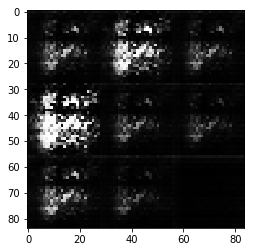

Epoch 1/2...  D loss: 1.0163  G loss: 4.7927
Epoch 1/2...  D loss: 0.6119  G loss: 1.6242
Epoch 1/2...  D loss: 0.9063  G loss: 5.7030
Epoch 1/2...  D loss: 0.3927  G loss: 3.3959
Epoch 1/2...  D loss: 0.5539  G loss: 2.0229
Epoch 1/2...  D loss: 0.6254  G loss: 2.2352
Epoch 1/2...  D loss: 0.8029  G loss: 2.0248
Epoch 1/2...  D loss: 1.0227  G loss: 3.2666
Epoch 1/2...  D loss: 1.1297  G loss: 4.6929
Epoch 1/2...  D loss: 0.5603  G loss: 2.1020


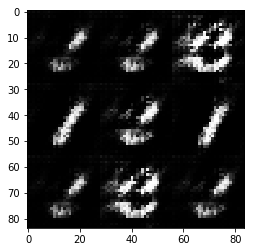

Epoch 1/2...  D loss: 0.7594  G loss: 2.6041
Epoch 1/2...  D loss: 1.2026  G loss: 3.1136
Epoch 1/2...  D loss: 0.4882  G loss: 3.1330
Epoch 1/2...  D loss: 1.3482  G loss: 6.4806
Epoch 1/2...  D loss: 0.5517  G loss: 2.1270
Epoch 1/2...  D loss: 0.5988  G loss: 1.9414
Epoch 1/2...  D loss: 1.7522  G loss: 6.2770
Epoch 1/2...  D loss: 0.7195  G loss: 2.5604
Epoch 1/2...  D loss: 0.7916  G loss: 3.8353
Epoch 1/2...  D loss: 0.6272  G loss: 3.6896


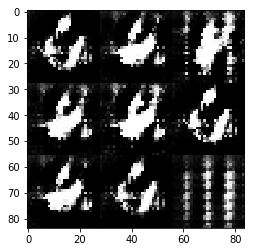

Epoch 1/2...  D loss: 1.0062  G loss: 6.0872
Epoch 1/2...  D loss: 1.6569  G loss: 6.3280
Epoch 1/2...  D loss: 0.8173  G loss: 3.4877
Epoch 1/2...  D loss: 1.0451  G loss: 4.9991
Epoch 1/2...  D loss: 0.6670  G loss: 2.2735
Epoch 1/2...  D loss: 0.5230  G loss: 2.4094
Epoch 1/2...  D loss: 1.6392  G loss: 6.0530
Epoch 1/2...  D loss: 0.6605  G loss: 3.0130
Epoch 1/2...  D loss: 0.8222  G loss: 1.3797
Epoch 1/2...  D loss: 0.6374  G loss: 1.8332


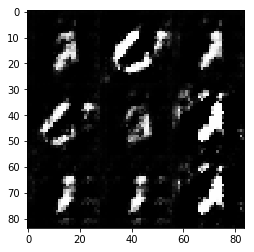

Epoch 1/2...  D loss: 0.6899  G loss: 2.0268
Epoch 1/2...  D loss: 0.5909  G loss: 1.8348
Epoch 1/2...  D loss: 0.6746  G loss: 1.7727
Epoch 1/2...  D loss: 0.5274  G loss: 2.2548
Epoch 1/2...  D loss: 0.6488  G loss: 2.5471
Epoch 1/2...  D loss: 0.5648  G loss: 2.6500
Epoch 1/2...  D loss: 0.5414  G loss: 2.9638
Epoch 1/2...  D loss: 0.6138  G loss: 3.2250
Epoch 1/2...  D loss: 0.6658  G loss: 1.9773
Epoch 1/2...  D loss: 0.6386  G loss: 3.0102


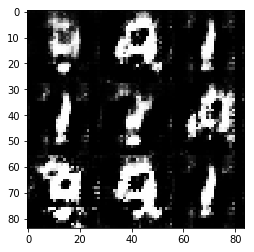

Epoch 1/2...  D loss: 0.7201  G loss: 3.2786
Epoch 1/2...  D loss: 1.0690  G loss: 4.0582
Epoch 1/2...  D loss: 0.9895  G loss: 3.5235
Epoch 1/2...  D loss: 0.7649  G loss: 2.4858
Epoch 1/2...  D loss: 0.5151  G loss: 2.4618
Epoch 1/2...  D loss: 0.6694  G loss: 1.7770
Epoch 1/2...  D loss: 0.7474  G loss: 1.4374
Epoch 1/2...  D loss: 0.7441  G loss: 2.9508
Epoch 1/2...  D loss: 0.6274  G loss: 2.1286
Epoch 1/2...  D loss: 0.7081  G loss: 2.6339


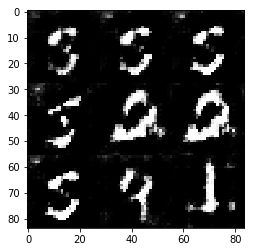

Epoch 1/2...  D loss: 0.9524  G loss: 3.3414
Epoch 1/2...  D loss: 0.8949  G loss: 2.4012
Epoch 1/2...  D loss: 0.7680  G loss: 2.4812
Epoch 1/2...  D loss: 0.6786  G loss: 1.6330
Epoch 1/2...  D loss: 0.7132  G loss: 1.7916
Epoch 1/2...  D loss: 0.8349  G loss: 1.3021
Epoch 1/2...  D loss: 0.7076  G loss: 2.0174
Epoch 1/2...  D loss: 0.9030  G loss: 3.6778
Epoch 1/2...  D loss: 1.0244  G loss: 3.7127
Epoch 1/2...  D loss: 0.6688  G loss: 1.6136


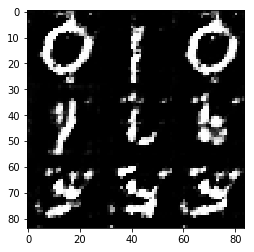

Epoch 1/2...  D loss: 0.6462  G loss: 1.8036
Epoch 1/2...  D loss: 0.8927  G loss: 1.5229
Epoch 1/2...  D loss: 0.8465  G loss: 1.8773
Epoch 1/2...  D loss: 0.6900  G loss: 2.9993
Epoch 1/2...  D loss: 0.9588  G loss: 1.0115
Epoch 1/2...  D loss: 0.7342  G loss: 1.5759
Epoch 1/2...  D loss: 1.1477  G loss: 3.9197
Epoch 1/2...  D loss: 0.8317  G loss: 2.7566
Epoch 1/2...  D loss: 0.7575  G loss: 1.9709
Epoch 1/2...  D loss: 1.1131  G loss: 2.9451


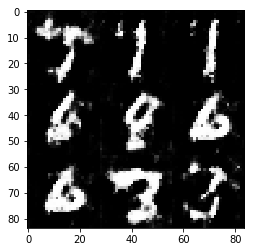

Epoch 1/2...  D loss: 0.8304  G loss: 2.7276
Epoch 1/2...  D loss: 0.7917  G loss: 1.2865
Epoch 1/2...  D loss: 0.7248  G loss: 1.2357
Epoch 1/2...  D loss: 0.6852  G loss: 2.1412
Epoch 1/2...  D loss: 0.5941  G loss: 1.8804
Epoch 1/2...  D loss: 0.9134  G loss: 2.6996
Epoch 1/2...  D loss: 1.0573  G loss: 3.1322
Epoch 1/2...  D loss: 0.7328  G loss: 1.6156
Epoch 1/2...  D loss: 0.9345  G loss: 0.8919
Epoch 1/2...  D loss: 0.7701  G loss: 1.3632


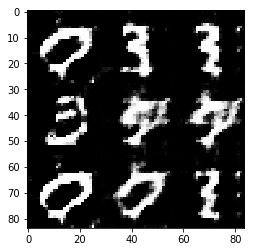

Epoch 1/2...  D loss: 0.7846  G loss: 2.3202
Epoch 1/2...  D loss: 1.0075  G loss: 2.0177
Epoch 1/2...  D loss: 0.9064  G loss: 2.1906
Epoch 1/2...  D loss: 0.6857  G loss: 1.5077
Epoch 1/2...  D loss: 0.7697  G loss: 1.2969
Epoch 1/2...  D loss: 0.8060  G loss: 1.3647
Epoch 1/2...  D loss: 0.8785  G loss: 1.5785
Epoch 1/2...  D loss: 0.8487  G loss: 2.3086
Epoch 1/2...  D loss: 0.8941  G loss: 2.0828
Epoch 1/2...  D loss: 0.7531  G loss: 1.5003


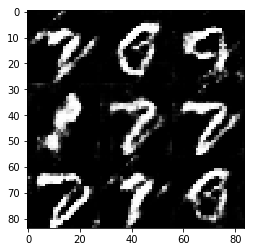

Epoch 1/2...  D loss: 0.6132  G loss: 2.1597
Epoch 1/2...  D loss: 0.5460  G loss: 1.8038
Epoch 1/2...  D loss: 1.1723  G loss: 2.7362
Epoch 1/2...  D loss: 0.8497  G loss: 2.6193
Epoch 1/2...  D loss: 0.7183  G loss: 1.2970
Epoch 1/2...  D loss: 0.7562  G loss: 2.2949
Epoch 1/2...  D loss: 0.6165  G loss: 1.9550
Epoch 1/2...  D loss: 0.9190  G loss: 2.2499
Epoch 1/2...  D loss: 0.7561  G loss: 1.7428
Epoch 1/2...  D loss: 0.7624  G loss: 1.8283


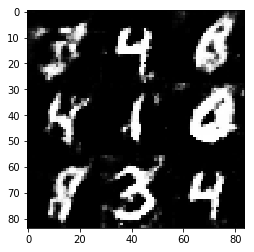

Epoch 1/2...  D loss: 0.7522  G loss: 2.4289
Epoch 1/2...  D loss: 0.6614  G loss: 1.5519
Epoch 1/2...  D loss: 0.7916  G loss: 1.8694
Epoch 1/2...  D loss: 0.6123  G loss: 1.6611
Epoch 1/2...  D loss: 0.8064  G loss: 1.4332
Epoch 1/2...  D loss: 0.6992  G loss: 2.1593
Epoch 1/2...  D loss: 0.8090  G loss: 1.2456
Epoch 1/2...  D loss: 0.7553  G loss: 1.3998
Epoch 1/2...  D loss: 0.8260  G loss: 1.4548
Epoch 1/2...  D loss: 0.8935  G loss: 0.9929


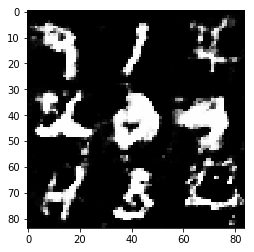

Epoch 1/2...  D loss: 0.9195  G loss: 2.0437
Epoch 1/2...  D loss: 0.7964  G loss: 1.1625
Epoch 1/2...  D loss: 0.7894  G loss: 2.3614
Epoch 1/2...  D loss: 0.7304  G loss: 1.6460
Epoch 1/2...  D loss: 0.8077  G loss: 1.1321
Epoch 1/2...  D loss: 0.9134  G loss: 1.1323
Epoch 1/2...  D loss: 0.8906  G loss: 1.6758
Epoch 1/2...  D loss: 0.8208  G loss: 1.6385
Epoch 1/2...  D loss: 0.9796  G loss: 0.8376
Epoch 1/2...  D loss: 0.8188  G loss: 1.2976


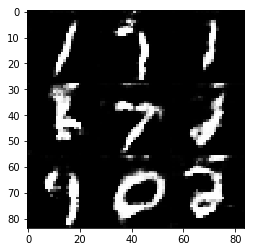

Epoch 1/2...  D loss: 1.0475  G loss: 2.4846
Epoch 1/2...  D loss: 1.1100  G loss: 1.9471
Epoch 1/2...  D loss: 0.7535  G loss: 1.8471
Epoch 1/2...  D loss: 0.7033  G loss: 1.3410
Epoch 1/2...  D loss: 0.9431  G loss: 2.3812
Epoch 1/2...  D loss: 0.8866  G loss: 2.5555
Epoch 1/2...  D loss: 0.8575  G loss: 1.2465
Epoch 1/2...  D loss: 1.0145  G loss: 0.8873
Epoch 1/2...  D loss: 0.8694  G loss: 2.1248
Epoch 1/2...  D loss: 0.8113  G loss: 2.3610


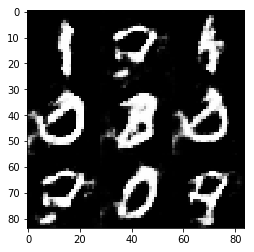

Epoch 1/2...  D loss: 0.6557  G loss: 1.5524
Epoch 1/2...  D loss: 0.7447  G loss: 1.5458
Epoch 1/2...  D loss: 0.8587  G loss: 1.2030
Epoch 1/2...  D loss: 0.8275  G loss: 1.6383
Epoch 1/2...  D loss: 1.0271  G loss: 0.8126
Epoch 1/2...  D loss: 0.9292  G loss: 2.1635
Epoch 1/2...  D loss: 0.9470  G loss: 0.8453
Epoch 1/2...  D loss: 0.8848  G loss: 1.8917
Epoch 1/2...  D loss: 0.8869  G loss: 0.9927
Epoch 1/2...  D loss: 0.9118  G loss: 1.2231


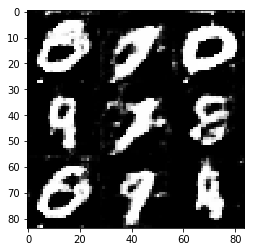

Epoch 1/2...  D loss: 0.7585  G loss: 1.7332
Epoch 1/2...  D loss: 0.8816  G loss: 1.4900
Epoch 1/2...  D loss: 0.8438  G loss: 1.2532
Epoch 1/2...  D loss: 1.0273  G loss: 2.4458
Epoch 1/2...  D loss: 0.8017  G loss: 2.0894
Epoch 1/2...  D loss: 0.8875  G loss: 1.4158
Epoch 1/2...  D loss: 0.8108  G loss: 1.8996
Epoch 1/2...  D loss: 0.9061  G loss: 2.5611
Epoch 1/2...  D loss: 0.8878  G loss: 0.9584
Epoch 1/2...  D loss: 0.7415  G loss: 1.6433


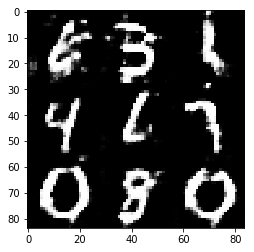

Epoch 1/2...  D loss: 0.6730  G loss: 1.6611
Epoch 1/2...  D loss: 0.6480  G loss: 1.6607
Epoch 1/2...  D loss: 0.6683  G loss: 1.5218
Epoch 1/2...  D loss: 0.7407  G loss: 1.2522
Epoch 1/2...  D loss: 0.8709  G loss: 1.0320
Epoch 1/2...  D loss: 0.8244  G loss: 2.0749
Epoch 1/2...  D loss: 0.7699  G loss: 1.6965
Epoch 1/2...  D loss: 0.8691  G loss: 0.9545
Epoch 1/2...  D loss: 0.7405  G loss: 1.2264
Epoch 1/2...  D loss: 0.9822  G loss: 2.7374


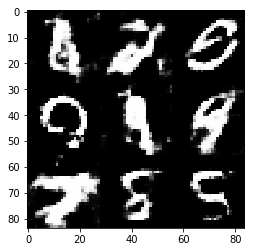

Epoch 1/2...  D loss: 0.9720  G loss: 1.8998
Epoch 1/2...  D loss: 0.7634  G loss: 1.2872
Epoch 1/2...  D loss: 0.8145  G loss: 1.1748
Epoch 1/2...  D loss: 0.9100  G loss: 1.1486
Epoch 1/2...  D loss: 0.8313  G loss: 1.4348
Epoch 1/2...  D loss: 1.0484  G loss: 0.8440
Epoch 1/2...  D loss: 0.7916  G loss: 1.1585
Epoch 1/2...  D loss: 0.7682  G loss: 1.6192
Epoch 1/2...  D loss: 0.8107  G loss: 1.1431
Epoch 1/2...  D loss: 0.7313  G loss: 1.3035


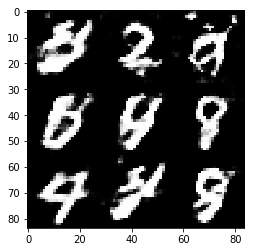

Epoch 1/2...  D loss: 1.0191  G loss: 2.5499
Epoch 1/2...  D loss: 0.8342  G loss: 1.6389
Epoch 1/2...  D loss: 1.0589  G loss: 0.7946
Epoch 1/2...  D loss: 0.9036  G loss: 2.2915
Epoch 1/2...  D loss: 0.7056  G loss: 2.0298
Epoch 1/2...  D loss: 1.0145  G loss: 1.9960
Epoch 1/2...  D loss: 0.7958  G loss: 1.2170
Epoch 2/2...  D loss: 0.9467  G loss: 0.9099
Epoch 2/2...  D loss: 0.7200  G loss: 1.6584
Epoch 2/2...  D loss: 0.7593  G loss: 1.4887


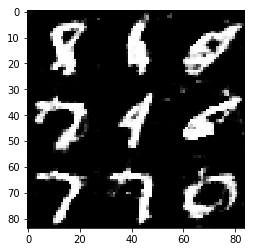

Epoch 2/2...  D loss: 0.9191  G loss: 2.0739
Epoch 2/2...  D loss: 1.0365  G loss: 2.6258
Epoch 2/2...  D loss: 0.7469  G loss: 1.4654
Epoch 2/2...  D loss: 1.0275  G loss: 2.3617
Epoch 2/2...  D loss: 1.0826  G loss: 0.8053
Epoch 2/2...  D loss: 1.1260  G loss: 0.7383
Epoch 2/2...  D loss: 0.7783  G loss: 1.7972
Epoch 2/2...  D loss: 0.8295  G loss: 1.3808
Epoch 2/2...  D loss: 0.9013  G loss: 1.8249
Epoch 2/2...  D loss: 1.0173  G loss: 2.6138


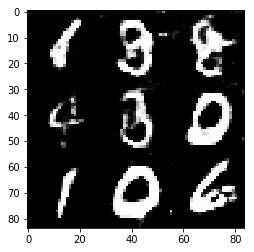

Epoch 2/2...  D loss: 0.8533  G loss: 1.0437
Epoch 2/2...  D loss: 0.8030  G loss: 1.1793
Epoch 2/2...  D loss: 0.8332  G loss: 1.2345
Epoch 2/2...  D loss: 0.7913  G loss: 1.8975
Epoch 2/2...  D loss: 1.1870  G loss: 2.7508
Epoch 2/2...  D loss: 1.0179  G loss: 2.3258
Epoch 2/2...  D loss: 0.8407  G loss: 1.4043
Epoch 2/2...  D loss: 0.8396  G loss: 1.1684
Epoch 2/2...  D loss: 0.7810  G loss: 1.6476
Epoch 2/2...  D loss: 0.7237  G loss: 1.4712


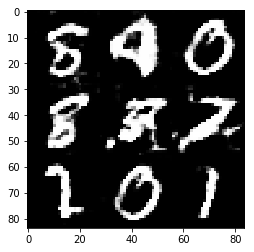

Epoch 2/2...  D loss: 0.8608  G loss: 1.1295
Epoch 2/2...  D loss: 0.8175  G loss: 1.6752
Epoch 2/2...  D loss: 0.8762  G loss: 1.1634
Epoch 2/2...  D loss: 0.7479  G loss: 1.4448
Epoch 2/2...  D loss: 0.6832  G loss: 2.0492
Epoch 2/2...  D loss: 0.8720  G loss: 0.9629
Epoch 2/2...  D loss: 0.9073  G loss: 0.9600
Epoch 2/2...  D loss: 0.8754  G loss: 1.7653
Epoch 2/2...  D loss: 0.9134  G loss: 2.1610
Epoch 2/2...  D loss: 0.8181  G loss: 2.2926


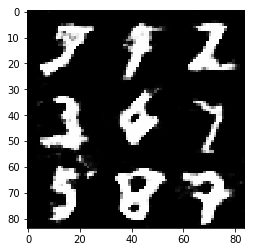

Epoch 2/2...  D loss: 0.6653  G loss: 1.4990
Epoch 2/2...  D loss: 0.7359  G loss: 1.5777
Epoch 2/2...  D loss: 0.6697  G loss: 1.7495
Epoch 2/2...  D loss: 0.7499  G loss: 1.8377
Epoch 2/2...  D loss: 0.7132  G loss: 1.3730
Epoch 2/2...  D loss: 0.8190  G loss: 1.7884
Epoch 2/2...  D loss: 0.7993  G loss: 1.4028
Epoch 2/2...  D loss: 0.8107  G loss: 2.1492
Epoch 2/2...  D loss: 0.8666  G loss: 1.0030
Epoch 2/2...  D loss: 0.9033  G loss: 2.4025


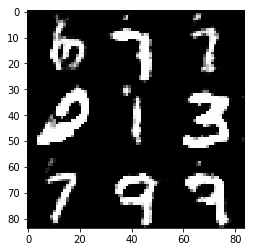

Epoch 2/2...  D loss: 0.8099  G loss: 1.0787
Epoch 2/2...  D loss: 0.7222  G loss: 1.2250
Epoch 2/2...  D loss: 0.6124  G loss: 1.8528
Epoch 2/2...  D loss: 0.7086  G loss: 1.3656
Epoch 2/2...  D loss: 0.7265  G loss: 1.8321
Epoch 2/2...  D loss: 0.7968  G loss: 1.1503
Epoch 2/2...  D loss: 0.6933  G loss: 1.5908
Epoch 2/2...  D loss: 0.9510  G loss: 0.8541
Epoch 2/2...  D loss: 0.8593  G loss: 1.0768
Epoch 2/2...  D loss: 0.8198  G loss: 1.0655


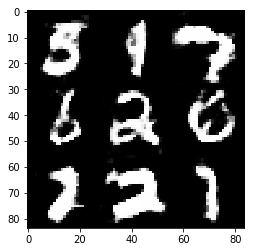

Epoch 2/2...  D loss: 0.8056  G loss: 1.8221
Epoch 2/2...  D loss: 1.2305  G loss: 2.4867
Epoch 2/2...  D loss: 0.8231  G loss: 1.1360
Epoch 2/2...  D loss: 1.1975  G loss: 2.8152
Epoch 2/2...  D loss: 0.9955  G loss: 1.9584
Epoch 2/2...  D loss: 0.8122  G loss: 1.4651
Epoch 2/2...  D loss: 0.7220  G loss: 1.2569
Epoch 2/2...  D loss: 0.6556  G loss: 1.4791
Epoch 2/2...  D loss: 0.7298  G loss: 1.3580
Epoch 2/2...  D loss: 1.0657  G loss: 2.0732


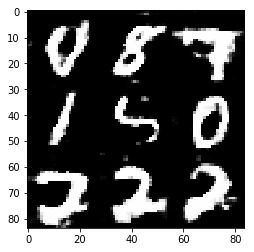

Epoch 2/2...  D loss: 0.9623  G loss: 0.9106
Epoch 2/2...  D loss: 0.8801  G loss: 1.4749
Epoch 2/2...  D loss: 1.0003  G loss: 0.8342
Epoch 2/2...  D loss: 0.6689  G loss: 1.7465
Epoch 2/2...  D loss: 0.7847  G loss: 2.0314
Epoch 2/2...  D loss: 0.8278  G loss: 1.0947
Epoch 2/2...  D loss: 0.9580  G loss: 2.2948
Epoch 2/2...  D loss: 0.8315  G loss: 1.0140
Epoch 2/2...  D loss: 1.1833  G loss: 0.7117
Epoch 2/2...  D loss: 0.7489  G loss: 1.2476


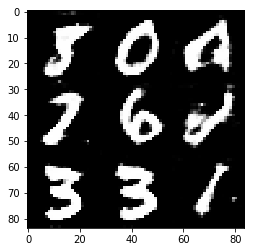

Epoch 2/2...  D loss: 0.8414  G loss: 1.8543
Epoch 2/2...  D loss: 0.8947  G loss: 2.1993
Epoch 2/2...  D loss: 0.8769  G loss: 1.9298
Epoch 2/2...  D loss: 0.7821  G loss: 1.2633
Epoch 2/2...  D loss: 1.0250  G loss: 2.1945
Epoch 2/2...  D loss: 0.8085  G loss: 1.2423
Epoch 2/2...  D loss: 0.8415  G loss: 1.4227
Epoch 2/2...  D loss: 0.9243  G loss: 1.0045
Epoch 2/2...  D loss: 0.7783  G loss: 1.2192
Epoch 2/2...  D loss: 0.7833  G loss: 1.3526


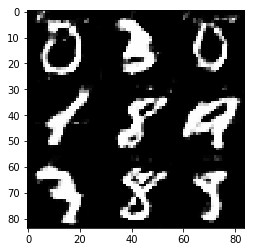

Epoch 2/2...  D loss: 0.8874  G loss: 0.9905
Epoch 2/2...  D loss: 0.8562  G loss: 2.0419
Epoch 2/2...  D loss: 0.7836  G loss: 1.4148
Epoch 2/2...  D loss: 1.2380  G loss: 2.7412
Epoch 2/2...  D loss: 0.7818  G loss: 1.7731
Epoch 2/2...  D loss: 0.7955  G loss: 1.2537
Epoch 2/2...  D loss: 1.0351  G loss: 2.1403
Epoch 2/2...  D loss: 0.9270  G loss: 1.8314
Epoch 2/2...  D loss: 0.8533  G loss: 1.1155
Epoch 2/2...  D loss: 0.7805  G loss: 2.0316


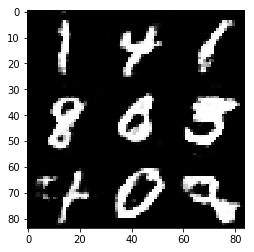

Epoch 2/2...  D loss: 0.7914  G loss: 1.9029
Epoch 2/2...  D loss: 0.9507  G loss: 2.2170
Epoch 2/2...  D loss: 0.7822  G loss: 1.2998
Epoch 2/2...  D loss: 0.8541  G loss: 1.3197
Epoch 2/2...  D loss: 1.0261  G loss: 2.5176
Epoch 2/2...  D loss: 0.9609  G loss: 0.8336
Epoch 2/2...  D loss: 0.7669  G loss: 1.5556
Epoch 2/2...  D loss: 0.7472  G loss: 1.4145
Epoch 2/2...  D loss: 0.9687  G loss: 2.5221
Epoch 2/2...  D loss: 0.8825  G loss: 0.9898


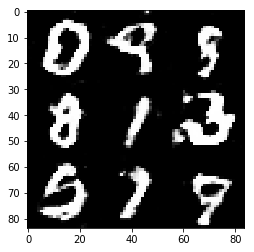

Epoch 2/2...  D loss: 0.9776  G loss: 2.4239
Epoch 2/2...  D loss: 1.0775  G loss: 0.7761
Epoch 2/2...  D loss: 1.0627  G loss: 2.1725
Epoch 2/2...  D loss: 1.0987  G loss: 2.0514
Epoch 2/2...  D loss: 0.7192  G loss: 1.4948
Epoch 2/2...  D loss: 0.9450  G loss: 1.7920
Epoch 2/2...  D loss: 1.0122  G loss: 2.0814
Epoch 2/2...  D loss: 0.8294  G loss: 1.0663
Epoch 2/2...  D loss: 0.7952  G loss: 1.5356
Epoch 2/2...  D loss: 0.8339  G loss: 2.0607


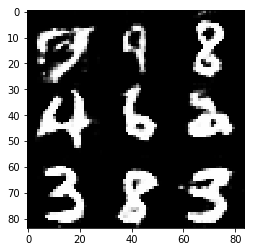

Epoch 2/2...  D loss: 0.7395  G loss: 1.7632
Epoch 2/2...  D loss: 0.6919  G loss: 1.8079
Epoch 2/2...  D loss: 0.7885  G loss: 1.2540
Epoch 2/2...  D loss: 0.7027  G loss: 1.6436
Epoch 2/2...  D loss: 0.9299  G loss: 1.7733
Epoch 2/2...  D loss: 0.8415  G loss: 1.7946
Epoch 2/2...  D loss: 0.8098  G loss: 1.8618
Epoch 2/2...  D loss: 0.8619  G loss: 1.3167
Epoch 2/2...  D loss: 0.9231  G loss: 0.9457
Epoch 2/2...  D loss: 0.9770  G loss: 2.0609


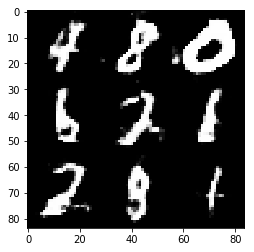

Epoch 2/2...  D loss: 0.8203  G loss: 1.6178
Epoch 2/2...  D loss: 0.7926  G loss: 1.1518
Epoch 2/2...  D loss: 0.8219  G loss: 1.6469
Epoch 2/2...  D loss: 0.7537  G loss: 1.4510
Epoch 2/2...  D loss: 0.8804  G loss: 1.5877
Epoch 2/2...  D loss: 0.9826  G loss: 1.9867
Epoch 2/2...  D loss: 0.9483  G loss: 2.0180
Epoch 2/2...  D loss: 1.2459  G loss: 2.5845
Epoch 2/2...  D loss: 0.9845  G loss: 0.9008
Epoch 2/2...  D loss: 0.9974  G loss: 0.8566


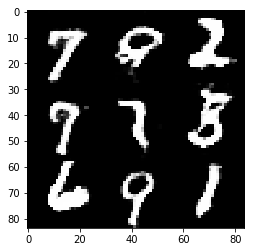

Epoch 2/2...  D loss: 0.8995  G loss: 0.9530
Epoch 2/2...  D loss: 0.9425  G loss: 0.9403
Epoch 2/2...  D loss: 0.9970  G loss: 0.8048
Epoch 2/2...  D loss: 0.8662  G loss: 1.7009
Epoch 2/2...  D loss: 0.7342  G loss: 1.3151
Epoch 2/2...  D loss: 0.8588  G loss: 1.3822
Epoch 2/2...  D loss: 1.0554  G loss: 0.8026
Epoch 2/2...  D loss: 0.8052  G loss: 1.0682
Epoch 2/2...  D loss: 0.7371  G loss: 1.3377
Epoch 2/2...  D loss: 0.7983  G loss: 1.7651


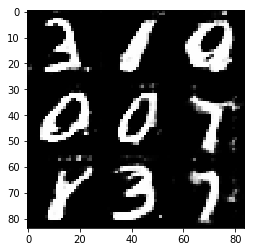

Epoch 2/2...  D loss: 1.0413  G loss: 0.7594
Epoch 2/2...  D loss: 1.1198  G loss: 0.7025
Epoch 2/2...  D loss: 0.8566  G loss: 1.0947
Epoch 2/2...  D loss: 0.6982  G loss: 1.2555
Epoch 2/2...  D loss: 0.7926  G loss: 1.7819
Epoch 2/2...  D loss: 0.7541  G loss: 1.4172
Epoch 2/2...  D loss: 0.8502  G loss: 1.1207
Epoch 2/2...  D loss: 0.6695  G loss: 1.4270
Epoch 2/2...  D loss: 0.8902  G loss: 1.9918
Epoch 2/2...  D loss: 0.8519  G loss: 1.4466


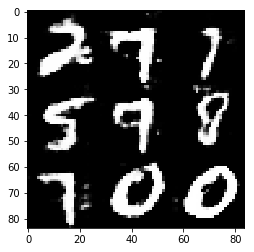

Epoch 2/2...  D loss: 0.8165  G loss: 1.1117
Epoch 2/2...  D loss: 1.0713  G loss: 0.7977
Epoch 2/2...  D loss: 0.9999  G loss: 1.4885
Epoch 2/2...  D loss: 0.8467  G loss: 0.9964
Epoch 2/2...  D loss: 0.7222  G loss: 1.3144
Epoch 2/2...  D loss: 0.9269  G loss: 1.6454
Epoch 2/2...  D loss: 0.7133  G loss: 1.3168
Epoch 2/2...  D loss: 1.2999  G loss: 2.5244
Epoch 2/2...  D loss: 0.8574  G loss: 1.2643
Epoch 2/2...  D loss: 0.9312  G loss: 0.9649


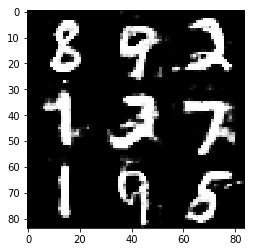

Epoch 2/2...  D loss: 0.8368  G loss: 1.6330
Epoch 2/2...  D loss: 1.0514  G loss: 1.6852
Epoch 2/2...  D loss: 0.8486  G loss: 1.8039
Epoch 2/2...  D loss: 1.1114  G loss: 0.6858
Epoch 2/2...  D loss: 0.7959  G loss: 1.1193
Epoch 2/2...  D loss: 0.8365  G loss: 1.0122
Epoch 2/2...  D loss: 0.8288  G loss: 1.1162
Epoch 2/2...  D loss: 0.9265  G loss: 1.2897
Epoch 2/2...  D loss: 1.0586  G loss: 2.1300
Epoch 2/2...  D loss: 0.8251  G loss: 1.4336


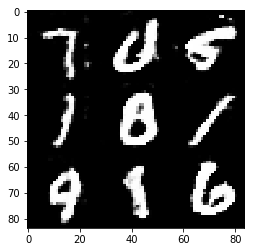

Epoch 2/2...  D loss: 0.8661  G loss: 1.9984
Epoch 2/2...  D loss: 0.8170  G loss: 1.2117
Epoch 2/2...  D loss: 0.8227  G loss: 1.2858
Epoch 2/2...  D loss: 0.7814  G loss: 1.4096
Epoch 2/2...  D loss: 1.0431  G loss: 2.2376
Epoch 2/2...  D loss: 0.9513  G loss: 0.8817
Epoch 2/2...  D loss: 0.8384  G loss: 1.2705
Epoch 2/2...  D loss: 0.8739  G loss: 1.0715
Epoch 2/2...  D loss: 0.8632  G loss: 1.0647
Epoch 2/2...  D loss: 0.8506  G loss: 1.0630


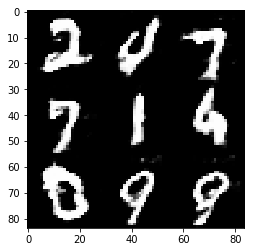

Epoch 2/2...  D loss: 0.8942  G loss: 0.9378
Epoch 2/2...  D loss: 0.9252  G loss: 1.0465
Epoch 2/2...  D loss: 0.8000  G loss: 1.6838
Epoch 2/2...  D loss: 0.8789  G loss: 1.2746


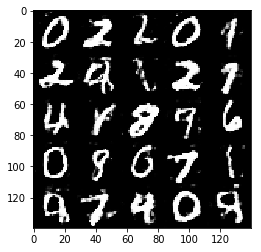

In [80]:
# AE: Just some starting values. Trying to fill the z vector with as many random values as will be used. Introduced 
# AE: configurable alpha, reduced learning rate
#batch_size = 500
#z_dim = 1024
#learning_rate = 0.01
#beta1 = 0.4
#alpha=0.2

# AE: Generator loss was well above discriminator's. So I train the generator twice as much now and it seems to have improved
# AE: things, but generated pictures are still quite poor. Increasing beta value and giving more random values for z 
# AE: (the maximum now as it will only suse 512x2x2 values)
#batch_size = 500
#z_dim = 2048
#learning_rate = 0.01
#beta1 = 0.5
#alpha=0.2

# AE: Still bad, reducing learning rate.
#batch_size = 500
#z_dim = 2048
#learning_rate = 0.001
#beta1 = 0.5
#alpha=0.2

# AE: Still bad, increasing batch size and reducing random values in z vector.
#batch_size = 1200
#z_dim = 256
#learning_rate = 0.001
#beta1 = 0.5
#alpha=0.2

# AE: Still bad, going with values from DCGAN (house numbers) mini project.
#batch_size = 128
#z_dim = 100
#learning_rate = 0.0002
#beta1 = 0.5
#alpha=0.2

# AE: That was almost good. It generated decent enough 0 digits. Let's increase randomization in z vector.
#batch_size = 128
#z_dim = 512
#learning_rate = 0.0002
#beta1 = 0.5
#alpha=0.2

# AE: Worse again, reducing z vector randomisation and trying without the extra training step for generator.
#batch_size = 128
#z_dim = 100
#learning_rate = 0.0002
#beta1 = 0.5
#alpha=0.2

# AE: Just trying different lr, beta and alpha.
#batch_size = 128
#z_dim = 100
#learning_rate = 0.0003
#beta1 = 0.6
#alpha=0.1

# AE: Going back to what almost worked. Also, introduced xavier initialisation for Generator's con2d_transpose layers' weights,
# AE: also introduced ReLU activation function on the same layers.
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2

# AE: Finally out of desperation I included drop out layers in generator and changed the discriminator to take into account
# AE: all values in the final layer before output (by using padding='SAME' instead of 'VALID')

# AE: Removed the dropout layers and xavier initialisation from the generator, because it didn't seem to help generating faces

# AE: Removed ReLU activation function from generator's conv2d_transpose layers.
# AE: Normalised real images from [-0.5, -0.5] range to [-1, 1] range to conform to generator's images, which 
# AE: are in range of [-1, 1], because we use tanh activation function.
# AE: Started using Xavier initialiser once again for both generator's and discriminator's layer weights.
# AE: Re-introduced dropout layers for both discriminator and generator (this time AFTER batch normalisation layer).
# AE: Also setting the hyperparameters to what was recommended in first review:

# The beta1 is high. Values like 0.1 to 0.3 have shown to get best results.
# The batch size used is a bit too large. Try values like 16 to 32 for better results.
# The DCGAN with this architectural structure remains stable with lr between 0.0001 and 0.0008.

# AE: Also changed kernel size from (3, 3) to (8, 8) for conv2d and conv2d_transpose layers.
# AE: This seems to have improved things a lot. Bigger kernel with the same stride gives more
# AE: points to average with each stride and seems to improve results. I guess it could be compared
# AE: to paying more attention to the details in the image, when kernel size is bigger than stride.
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.2
alpha=0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1...  D loss: 0.4503  G loss: 10.7980
Epoch 1/1...  D loss: 1.1964  G loss: 2.9023
Epoch 1/1...  D loss: 1.3930  G loss: 3.6754
Epoch 1/1...  D loss: 0.9690  G loss: 1.1504
Epoch 1/1...  D loss: 0.8441  G loss: 1.0811
Epoch 1/1...  D loss: 0.8553  G loss: 1.5289
Epoch 1/1...  D loss: 0.9949  G loss: 1.3432
Epoch 1/1...  D loss: 0.9749  G loss: 1.0288
Epoch 1/1...  D loss: 1.0628  G loss: 1.0521
Epoch 1/1...  D loss: 0.8382  G loss: 1.4412


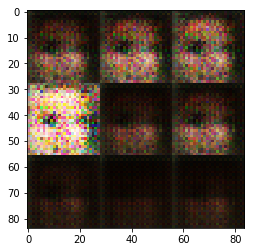

Epoch 1/1...  D loss: 0.7625  G loss: 1.3598
Epoch 1/1...  D loss: 1.1560  G loss: 1.6872
Epoch 1/1...  D loss: 1.1086  G loss: 1.0442
Epoch 1/1...  D loss: 1.1943  G loss: 0.9097
Epoch 1/1...  D loss: 1.0483  G loss: 0.9445
Epoch 1/1...  D loss: 1.0077  G loss: 1.0644
Epoch 1/1...  D loss: 1.0157  G loss: 1.0621
Epoch 1/1...  D loss: 0.9181  G loss: 1.4856
Epoch 1/1...  D loss: 1.0684  G loss: 0.8982
Epoch 1/1...  D loss: 1.2338  G loss: 0.8180


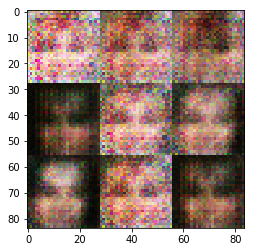

Epoch 1/1...  D loss: 1.2584  G loss: 0.8119
Epoch 1/1...  D loss: 1.2689  G loss: 0.8728
Epoch 1/1...  D loss: 1.2424  G loss: 0.8066
Epoch 1/1...  D loss: 1.3208  G loss: 1.0374
Epoch 1/1...  D loss: 1.2733  G loss: 1.2930
Epoch 1/1...  D loss: 1.2265  G loss: 1.0331
Epoch 1/1...  D loss: 1.3236  G loss: 0.8630
Epoch 1/1...  D loss: 1.2651  G loss: 0.8141
Epoch 1/1...  D loss: 1.3403  G loss: 0.7950
Epoch 1/1...  D loss: 1.3696  G loss: 0.8551


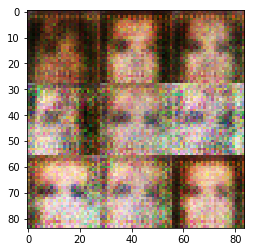

Epoch 1/1...  D loss: 1.2303  G loss: 0.9576
Epoch 1/1...  D loss: 1.2899  G loss: 0.8175
Epoch 1/1...  D loss: 1.3406  G loss: 0.8892
Epoch 1/1...  D loss: 1.2521  G loss: 0.8415
Epoch 1/1...  D loss: 1.3268  G loss: 0.9012
Epoch 1/1...  D loss: 1.3539  G loss: 0.8866
Epoch 1/1...  D loss: 1.2575  G loss: 0.8105
Epoch 1/1...  D loss: 1.3175  G loss: 0.6830
Epoch 1/1...  D loss: 1.3437  G loss: 0.7993
Epoch 1/1...  D loss: 1.2795  G loss: 0.9911


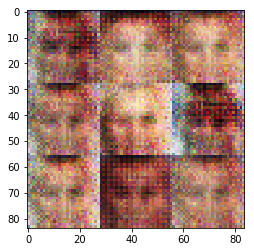

Epoch 1/1...  D loss: 1.2788  G loss: 0.8547
Epoch 1/1...  D loss: 1.2724  G loss: 0.8722
Epoch 1/1...  D loss: 1.3219  G loss: 0.8043
Epoch 1/1...  D loss: 1.3673  G loss: 0.8360
Epoch 1/1...  D loss: 1.2679  G loss: 0.7982
Epoch 1/1...  D loss: 1.3780  G loss: 0.8284
Epoch 1/1...  D loss: 1.3463  G loss: 0.8562
Epoch 1/1...  D loss: 1.2518  G loss: 0.8251
Epoch 1/1...  D loss: 1.2939  G loss: 0.8973
Epoch 1/1...  D loss: 1.3043  G loss: 0.8546


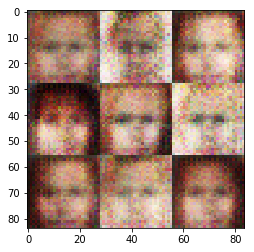

Epoch 1/1...  D loss: 1.3471  G loss: 0.8116
Epoch 1/1...  D loss: 1.3102  G loss: 0.7778
Epoch 1/1...  D loss: 1.2420  G loss: 0.8682
Epoch 1/1...  D loss: 1.3529  G loss: 0.8417
Epoch 1/1...  D loss: 1.2857  G loss: 0.8510
Epoch 1/1...  D loss: 1.2585  G loss: 0.8426
Epoch 1/1...  D loss: 1.2059  G loss: 0.8541
Epoch 1/1...  D loss: 1.3039  G loss: 0.7856
Epoch 1/1...  D loss: 1.3173  G loss: 0.8107
Epoch 1/1...  D loss: 1.3226  G loss: 0.8708


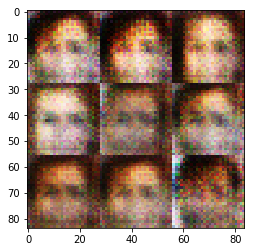

Epoch 1/1...  D loss: 1.2447  G loss: 0.8427
Epoch 1/1...  D loss: 1.2960  G loss: 0.8343
Epoch 1/1...  D loss: 1.2494  G loss: 0.7958
Epoch 1/1...  D loss: 1.3290  G loss: 0.8887
Epoch 1/1...  D loss: 1.3273  G loss: 0.9007
Epoch 1/1...  D loss: 1.2778  G loss: 0.8122
Epoch 1/1...  D loss: 1.3066  G loss: 0.8126
Epoch 1/1...  D loss: 1.3172  G loss: 1.1572
Epoch 1/1...  D loss: 1.2891  G loss: 0.8213
Epoch 1/1...  D loss: 1.3182  G loss: 0.8021


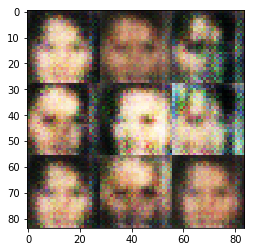

Epoch 1/1...  D loss: 1.3553  G loss: 0.8192
Epoch 1/1...  D loss: 1.3420  G loss: 0.8097
Epoch 1/1...  D loss: 1.3129  G loss: 0.9273
Epoch 1/1...  D loss: 1.3085  G loss: 0.7966
Epoch 1/1...  D loss: 1.3655  G loss: 0.9790
Epoch 1/1...  D loss: 1.3058  G loss: 0.8837
Epoch 1/1...  D loss: 1.3312  G loss: 0.7750
Epoch 1/1...  D loss: 1.3359  G loss: 0.7671
Epoch 1/1...  D loss: 1.2523  G loss: 0.9500
Epoch 1/1...  D loss: 1.3470  G loss: 0.8653


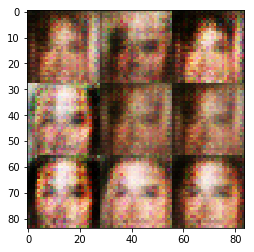

Epoch 1/1...  D loss: 1.2886  G loss: 0.8455
Epoch 1/1...  D loss: 1.3287  G loss: 0.8615
Epoch 1/1...  D loss: 1.3113  G loss: 0.7470
Epoch 1/1...  D loss: 1.2256  G loss: 0.8821
Epoch 1/1...  D loss: 1.2291  G loss: 0.7828
Epoch 1/1...  D loss: 1.3495  G loss: 0.9846
Epoch 1/1...  D loss: 1.3099  G loss: 0.9012
Epoch 1/1...  D loss: 1.3652  G loss: 0.8759
Epoch 1/1...  D loss: 1.3079  G loss: 0.9564
Epoch 1/1...  D loss: 1.2632  G loss: 0.9006


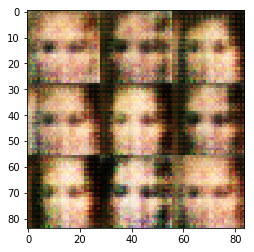

Epoch 1/1...  D loss: 1.3086  G loss: 0.7831
Epoch 1/1...  D loss: 1.2551  G loss: 0.7767
Epoch 1/1...  D loss: 1.2749  G loss: 0.8159
Epoch 1/1...  D loss: 1.2871  G loss: 0.8330
Epoch 1/1...  D loss: 1.3093  G loss: 0.7383
Epoch 1/1...  D loss: 1.2589  G loss: 0.8125
Epoch 1/1...  D loss: 1.2535  G loss: 0.8665
Epoch 1/1...  D loss: 1.3447  G loss: 0.7518
Epoch 1/1...  D loss: 1.2817  G loss: 0.9747
Epoch 1/1...  D loss: 1.3409  G loss: 0.8019


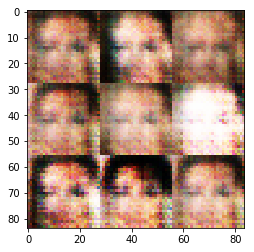

Epoch 1/1...  D loss: 1.2835  G loss: 0.8660
Epoch 1/1...  D loss: 1.3203  G loss: 0.8991
Epoch 1/1...  D loss: 1.3630  G loss: 0.7796
Epoch 1/1...  D loss: 1.2922  G loss: 0.7587
Epoch 1/1...  D loss: 1.3095  G loss: 0.7969
Epoch 1/1...  D loss: 1.2961  G loss: 0.8419
Epoch 1/1...  D loss: 1.2956  G loss: 0.7877
Epoch 1/1...  D loss: 1.2371  G loss: 0.8664
Epoch 1/1...  D loss: 1.2730  G loss: 0.8533
Epoch 1/1...  D loss: 1.2993  G loss: 0.8148


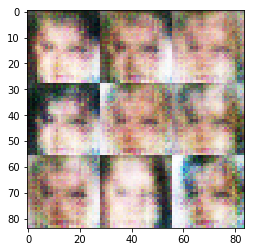

Epoch 1/1...  D loss: 1.3343  G loss: 0.8023
Epoch 1/1...  D loss: 1.3018  G loss: 0.8338
Epoch 1/1...  D loss: 1.3041  G loss: 0.8403
Epoch 1/1...  D loss: 1.2815  G loss: 0.8317
Epoch 1/1...  D loss: 1.3513  G loss: 0.9986
Epoch 1/1...  D loss: 1.3518  G loss: 0.8147
Epoch 1/1...  D loss: 1.2650  G loss: 0.7857
Epoch 1/1...  D loss: 1.2804  G loss: 0.8754
Epoch 1/1...  D loss: 1.3027  G loss: 0.9530
Epoch 1/1...  D loss: 1.3298  G loss: 0.9092


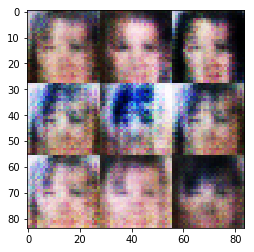

Epoch 1/1...  D loss: 1.2836  G loss: 0.8725
Epoch 1/1...  D loss: 1.3186  G loss: 0.7213
Epoch 1/1...  D loss: 1.3711  G loss: 0.8637
Epoch 1/1...  D loss: 1.3323  G loss: 0.7803
Epoch 1/1...  D loss: 1.3348  G loss: 0.8668
Epoch 1/1...  D loss: 1.3465  G loss: 0.8129
Epoch 1/1...  D loss: 1.3579  G loss: 0.8203
Epoch 1/1...  D loss: 1.3344  G loss: 0.8138
Epoch 1/1...  D loss: 1.3185  G loss: 0.7530
Epoch 1/1...  D loss: 1.3637  G loss: 0.8310


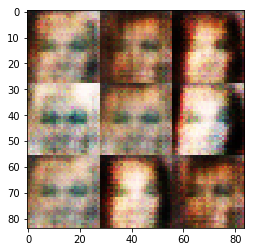

Epoch 1/1...  D loss: 1.3398  G loss: 0.8215
Epoch 1/1...  D loss: 1.2984  G loss: 0.8146
Epoch 1/1...  D loss: 1.3199  G loss: 0.8306
Epoch 1/1...  D loss: 1.3376  G loss: 0.7995
Epoch 1/1...  D loss: 1.3176  G loss: 0.8526
Epoch 1/1...  D loss: 1.2939  G loss: 0.9208
Epoch 1/1...  D loss: 1.2717  G loss: 0.8545
Epoch 1/1...  D loss: 1.3367  G loss: 0.8001
Epoch 1/1...  D loss: 1.3702  G loss: 0.7959
Epoch 1/1...  D loss: 1.3416  G loss: 0.7953


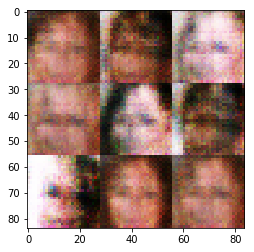

Epoch 1/1...  D loss: 1.3173  G loss: 0.8846
Epoch 1/1...  D loss: 1.3312  G loss: 0.7946
Epoch 1/1...  D loss: 1.3485  G loss: 0.7351
Epoch 1/1...  D loss: 1.3685  G loss: 0.7949
Epoch 1/1...  D loss: 1.3419  G loss: 0.9131
Epoch 1/1...  D loss: 1.3588  G loss: 0.7934
Epoch 1/1...  D loss: 1.3293  G loss: 0.8829
Epoch 1/1...  D loss: 1.3482  G loss: 0.8591
Epoch 1/1...  D loss: 1.3511  G loss: 0.7887
Epoch 1/1...  D loss: 1.3276  G loss: 0.7845


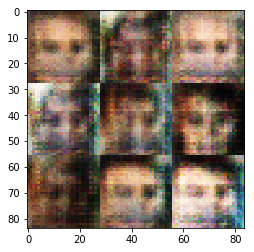

Epoch 1/1...  D loss: 1.3343  G loss: 0.7434
Epoch 1/1...  D loss: 1.2846  G loss: 1.0604
Epoch 1/1...  D loss: 1.2938  G loss: 0.8120
Epoch 1/1...  D loss: 1.3363  G loss: 0.7299
Epoch 1/1...  D loss: 1.3459  G loss: 0.7415
Epoch 1/1...  D loss: 1.3406  G loss: 0.8250
Epoch 1/1...  D loss: 1.3497  G loss: 0.7986
Epoch 1/1...  D loss: 1.3802  G loss: 0.9641
Epoch 1/1...  D loss: 1.2638  G loss: 0.8664
Epoch 1/1...  D loss: 1.3675  G loss: 1.2036


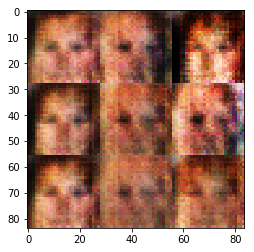

Epoch 1/1...  D loss: 1.3074  G loss: 0.8833
Epoch 1/1...  D loss: 1.3592  G loss: 0.8038
Epoch 1/1...  D loss: 1.3165  G loss: 0.8102
Epoch 1/1...  D loss: 1.3181  G loss: 0.7673
Epoch 1/1...  D loss: 1.3324  G loss: 0.7947
Epoch 1/1...  D loss: 1.2261  G loss: 0.8292
Epoch 1/1...  D loss: 1.3550  G loss: 0.8315
Epoch 1/1...  D loss: 1.3317  G loss: 0.9461
Epoch 1/1...  D loss: 1.2526  G loss: 1.0214
Epoch 1/1...  D loss: 1.2841  G loss: 0.8159


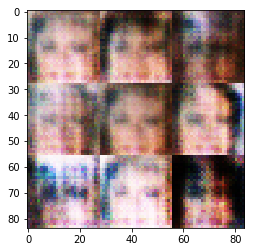

Epoch 1/1...  D loss: 1.3580  G loss: 0.8951
Epoch 1/1...  D loss: 1.3039  G loss: 0.8147
Epoch 1/1...  D loss: 1.3602  G loss: 0.8447
Epoch 1/1...  D loss: 1.3592  G loss: 0.9706
Epoch 1/1...  D loss: 1.3644  G loss: 0.7642
Epoch 1/1...  D loss: 1.2709  G loss: 0.8564
Epoch 1/1...  D loss: 1.3355  G loss: 0.7825
Epoch 1/1...  D loss: 1.3363  G loss: 0.8079
Epoch 1/1...  D loss: 1.2944  G loss: 0.8066
Epoch 1/1...  D loss: 1.3116  G loss: 0.8771


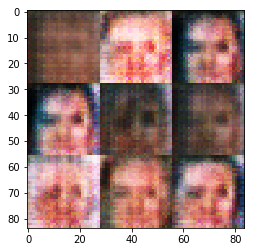

Epoch 1/1...  D loss: 1.3327  G loss: 0.8040
Epoch 1/1...  D loss: 1.3494  G loss: 0.7481
Epoch 1/1...  D loss: 1.3544  G loss: 0.8992
Epoch 1/1...  D loss: 1.3473  G loss: 0.8231
Epoch 1/1...  D loss: 1.3348  G loss: 0.7762
Epoch 1/1...  D loss: 1.3023  G loss: 0.7849
Epoch 1/1...  D loss: 1.2986  G loss: 0.7967
Epoch 1/1...  D loss: 1.3627  G loss: 0.7489
Epoch 1/1...  D loss: 1.3128  G loss: 0.8721
Epoch 1/1...  D loss: 1.3154  G loss: 0.8522


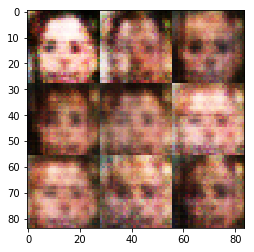

Epoch 1/1...  D loss: 1.2967  G loss: 0.8425
Epoch 1/1...  D loss: 1.2899  G loss: 0.9046
Epoch 1/1...  D loss: 1.3338  G loss: 0.8187
Epoch 1/1...  D loss: 1.3004  G loss: 0.8326
Epoch 1/1...  D loss: 1.2861  G loss: 0.8286
Epoch 1/1...  D loss: 1.3114  G loss: 0.8416
Epoch 1/1...  D loss: 1.3520  G loss: 0.8303
Epoch 1/1...  D loss: 1.2897  G loss: 0.8027
Epoch 1/1...  D loss: 1.3371  G loss: 0.8670
Epoch 1/1...  D loss: 1.3330  G loss: 0.8001


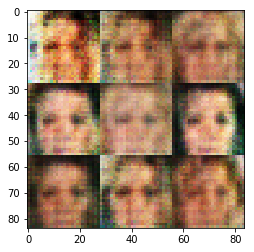

Epoch 1/1...  D loss: 1.3694  G loss: 0.8451
Epoch 1/1...  D loss: 1.2438  G loss: 0.8125
Epoch 1/1...  D loss: 1.3553  G loss: 0.7591
Epoch 1/1...  D loss: 1.3513  G loss: 0.7515
Epoch 1/1...  D loss: 1.3025  G loss: 0.7165
Epoch 1/1...  D loss: 1.3365  G loss: 0.7977
Epoch 1/1...  D loss: 1.3107  G loss: 0.8580
Epoch 1/1...  D loss: 1.3287  G loss: 0.7961
Epoch 1/1...  D loss: 1.3641  G loss: 0.8482
Epoch 1/1...  D loss: 1.3033  G loss: 0.7758


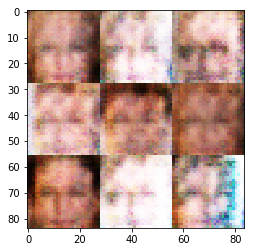

Epoch 1/1...  D loss: 1.2990  G loss: 0.9483
Epoch 1/1...  D loss: 1.3244  G loss: 0.8141
Epoch 1/1...  D loss: 1.2842  G loss: 1.1019
Epoch 1/1...  D loss: 1.2633  G loss: 0.8344
Epoch 1/1...  D loss: 1.3158  G loss: 0.8299
Epoch 1/1...  D loss: 1.3089  G loss: 0.9474
Epoch 1/1...  D loss: 1.2531  G loss: 0.8951
Epoch 1/1...  D loss: 1.2692  G loss: 0.8457
Epoch 1/1...  D loss: 1.3858  G loss: 0.8911
Epoch 1/1...  D loss: 1.3098  G loss: 0.9052


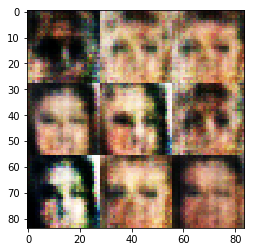

Epoch 1/1...  D loss: 1.2877  G loss: 0.8801
Epoch 1/1...  D loss: 1.2769  G loss: 0.7633
Epoch 1/1...  D loss: 1.3494  G loss: 0.8216
Epoch 1/1...  D loss: 1.3024  G loss: 0.7973
Epoch 1/1...  D loss: 1.2801  G loss: 0.8630
Epoch 1/1...  D loss: 1.3155  G loss: 0.8489
Epoch 1/1...  D loss: 1.2776  G loss: 0.7126
Epoch 1/1...  D loss: 1.2600  G loss: 0.8474
Epoch 1/1...  D loss: 1.2556  G loss: 0.8400
Epoch 1/1...  D loss: 1.3214  G loss: 0.9528


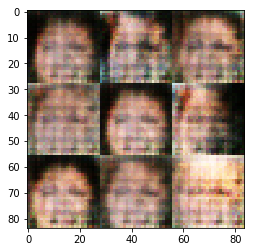

Epoch 1/1...  D loss: 1.2763  G loss: 0.9632
Epoch 1/1...  D loss: 1.2392  G loss: 0.8485
Epoch 1/1...  D loss: 1.2928  G loss: 0.7334
Epoch 1/1...  D loss: 1.2658  G loss: 0.8291
Epoch 1/1...  D loss: 1.3895  G loss: 0.7716
Epoch 1/1...  D loss: 1.2852  G loss: 0.7761
Epoch 1/1...  D loss: 1.2626  G loss: 0.9357
Epoch 1/1...  D loss: 1.3284  G loss: 0.9876
Epoch 1/1...  D loss: 1.1423  G loss: 0.8691
Epoch 1/1...  D loss: 1.3636  G loss: 0.8771


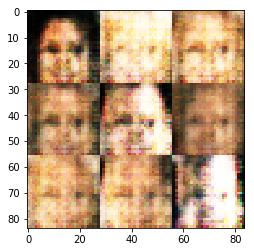

Epoch 1/1...  D loss: 1.2421  G loss: 0.8848
Epoch 1/1...  D loss: 1.2031  G loss: 0.8857
Epoch 1/1...  D loss: 1.1956  G loss: 0.8077
Epoch 1/1...  D loss: 1.2460  G loss: 0.9838
Epoch 1/1...  D loss: 1.2644  G loss: 1.1931
Epoch 1/1...  D loss: 1.3184  G loss: 0.7520
Epoch 1/1...  D loss: 1.1844  G loss: 0.9644
Epoch 1/1...  D loss: 1.3398  G loss: 0.8594
Epoch 1/1...  D loss: 1.3079  G loss: 0.8560
Epoch 1/1...  D loss: 1.3465  G loss: 0.8092


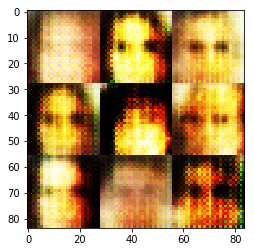

Epoch 1/1...  D loss: 1.3268  G loss: 0.7981
Epoch 1/1...  D loss: 1.3235  G loss: 0.7702
Epoch 1/1...  D loss: 1.3064  G loss: 0.7948
Epoch 1/1...  D loss: 1.3009  G loss: 0.8849
Epoch 1/1...  D loss: 1.3283  G loss: 0.8493
Epoch 1/1...  D loss: 1.3040  G loss: 0.8525
Epoch 1/1...  D loss: 1.3225  G loss: 0.8174
Epoch 1/1...  D loss: 1.3215  G loss: 0.7905
Epoch 1/1...  D loss: 1.3129  G loss: 0.7764
Epoch 1/1...  D loss: 1.3126  G loss: 0.7665


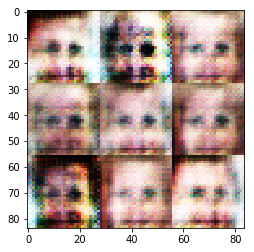

Epoch 1/1...  D loss: 1.2940  G loss: 0.8426
Epoch 1/1...  D loss: 1.2609  G loss: 0.8852
Epoch 1/1...  D loss: 1.3467  G loss: 0.7889
Epoch 1/1...  D loss: 1.3156  G loss: 0.7704
Epoch 1/1...  D loss: 1.3307  G loss: 0.8015
Epoch 1/1...  D loss: 1.3123  G loss: 0.8534
Epoch 1/1...  D loss: 1.3507  G loss: 0.8968
Epoch 1/1...  D loss: 1.3024  G loss: 0.7928
Epoch 1/1...  D loss: 1.2946  G loss: 0.8687
Epoch 1/1...  D loss: 1.2731  G loss: 0.8823


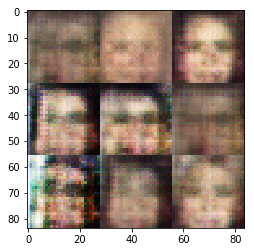

Epoch 1/1...  D loss: 1.3141  G loss: 0.7658
Epoch 1/1...  D loss: 1.3456  G loss: 0.8815
Epoch 1/1...  D loss: 1.2778  G loss: 0.8225
Epoch 1/1...  D loss: 1.2576  G loss: 0.8434
Epoch 1/1...  D loss: 1.3095  G loss: 1.0278
Epoch 1/1...  D loss: 1.3187  G loss: 0.7546
Epoch 1/1...  D loss: 1.3563  G loss: 0.8534
Epoch 1/1...  D loss: 1.3521  G loss: 0.7943
Epoch 1/1...  D loss: 1.3223  G loss: 0.7071
Epoch 1/1...  D loss: 1.2302  G loss: 0.8394


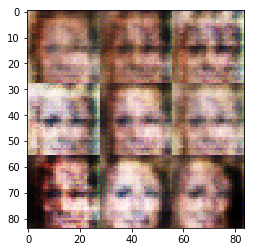

Epoch 1/1...  D loss: 1.3480  G loss: 0.8941
Epoch 1/1...  D loss: 1.2443  G loss: 1.0062
Epoch 1/1...  D loss: 1.3036  G loss: 0.8702
Epoch 1/1...  D loss: 1.3397  G loss: 0.8360
Epoch 1/1...  D loss: 1.2026  G loss: 0.9178
Epoch 1/1...  D loss: 1.3610  G loss: 0.7748
Epoch 1/1...  D loss: 1.3782  G loss: 0.8892
Epoch 1/1...  D loss: 1.3055  G loss: 0.8462
Epoch 1/1...  D loss: 1.3122  G loss: 0.8317
Epoch 1/1...  D loss: 1.2762  G loss: 0.9708


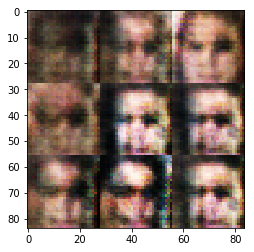

Epoch 1/1...  D loss: 1.2899  G loss: 0.7826
Epoch 1/1...  D loss: 1.3298  G loss: 0.8917
Epoch 1/1...  D loss: 1.2744  G loss: 0.8524
Epoch 1/1...  D loss: 1.3078  G loss: 0.7217
Epoch 1/1...  D loss: 1.2138  G loss: 0.8218
Epoch 1/1...  D loss: 1.3555  G loss: 0.8992
Epoch 1/1...  D loss: 1.2929  G loss: 0.8402
Epoch 1/1...  D loss: 1.2373  G loss: 0.8441
Epoch 1/1...  D loss: 1.2434  G loss: 0.8546
Epoch 1/1...  D loss: 1.3078  G loss: 0.7970


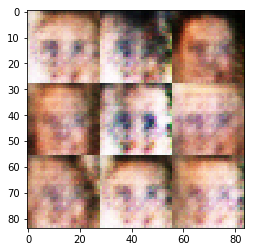

Epoch 1/1...  D loss: 1.2899  G loss: 0.9134
Epoch 1/1...  D loss: 1.3277  G loss: 0.7814
Epoch 1/1...  D loss: 1.3436  G loss: 0.8476
Epoch 1/1...  D loss: 1.2460  G loss: 1.0683
Epoch 1/1...  D loss: 1.2335  G loss: 0.9832
Epoch 1/1...  D loss: 1.2091  G loss: 1.0356
Epoch 1/1...  D loss: 1.1191  G loss: 0.8902
Epoch 1/1...  D loss: 1.3345  G loss: 0.8753
Epoch 1/1...  D loss: 1.3477  G loss: 0.8694
Epoch 1/1...  D loss: 1.3010  G loss: 0.8699


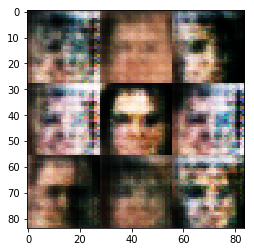

Epoch 1/1...  D loss: 1.3095  G loss: 0.8382
Epoch 1/1...  D loss: 1.2475  G loss: 0.9139
Epoch 1/1...  D loss: 1.2963  G loss: 0.8243
Epoch 1/1...  D loss: 1.2724  G loss: 0.7827
Epoch 1/1...  D loss: 1.3448  G loss: 0.8331
Epoch 1/1...  D loss: 1.3228  G loss: 0.8188
Epoch 1/1...  D loss: 1.3292  G loss: 0.7939
Epoch 1/1...  D loss: 1.2973  G loss: 1.0401
Epoch 1/1...  D loss: 1.2777  G loss: 0.7414
Epoch 1/1...  D loss: 1.3353  G loss: 0.8524


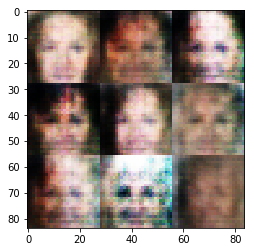

Epoch 1/1...  D loss: 1.2899  G loss: 0.8617
Epoch 1/1...  D loss: 1.3191  G loss: 0.9230
Epoch 1/1...  D loss: 1.3048  G loss: 0.8533
Epoch 1/1...  D loss: 1.2522  G loss: 0.9410
Epoch 1/1...  D loss: 1.2442  G loss: 0.8835
Epoch 1/1...  D loss: 1.2371  G loss: 0.8539
Epoch 1/1...  D loss: 1.3256  G loss: 0.7171
Epoch 1/1...  D loss: 1.3548  G loss: 0.7757
Epoch 1/1...  D loss: 1.2530  G loss: 0.8378
Epoch 1/1...  D loss: 1.2854  G loss: 0.7975


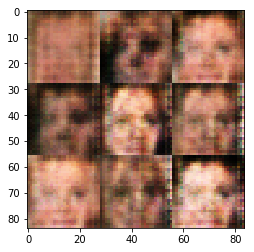

Epoch 1/1...  D loss: 1.3752  G loss: 1.6712
Epoch 1/1...  D loss: 1.2886  G loss: 0.9570
Epoch 1/1...  D loss: 1.3249  G loss: 0.8101
Epoch 1/1...  D loss: 1.3092  G loss: 0.7768
Epoch 1/1...  D loss: 1.2923  G loss: 0.9115
Epoch 1/1...  D loss: 1.2747  G loss: 0.9739
Epoch 1/1...  D loss: 1.2878  G loss: 0.9741
Epoch 1/1...  D loss: 1.2181  G loss: 0.9315
Epoch 1/1...  D loss: 1.3160  G loss: 0.8461
Epoch 1/1...  D loss: 1.2547  G loss: 0.7573


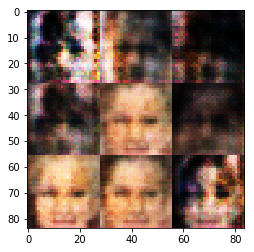

Epoch 1/1...  D loss: 1.2140  G loss: 0.9345
Epoch 1/1...  D loss: 1.3291  G loss: 0.7498
Epoch 1/1...  D loss: 1.3054  G loss: 0.8789
Epoch 1/1...  D loss: 1.3031  G loss: 0.8347
Epoch 1/1...  D loss: 0.9684  G loss: 1.0848
Epoch 1/1...  D loss: 1.3344  G loss: 0.8829
Epoch 1/1...  D loss: 1.3311  G loss: 0.7432
Epoch 1/1...  D loss: 1.2292  G loss: 0.7864
Epoch 1/1...  D loss: 1.3162  G loss: 0.8428
Epoch 1/1...  D loss: 1.3106  G loss: 0.8401


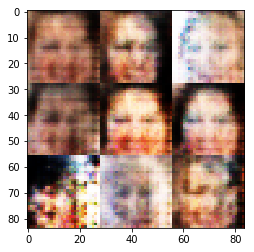

Epoch 1/1...  D loss: 1.3094  G loss: 1.3333
Epoch 1/1...  D loss: 1.3408  G loss: 0.8011
Epoch 1/1...  D loss: 1.3224  G loss: 0.9077
Epoch 1/1...  D loss: 1.3233  G loss: 0.8211
Epoch 1/1...  D loss: 1.2942  G loss: 0.7646
Epoch 1/1...  D loss: 1.2873  G loss: 0.8428
Epoch 1/1...  D loss: 1.2947  G loss: 0.8058
Epoch 1/1...  D loss: 1.3166  G loss: 0.8239
Epoch 1/1...  D loss: 1.3152  G loss: 0.7867
Epoch 1/1...  D loss: 1.3039  G loss: 0.9287


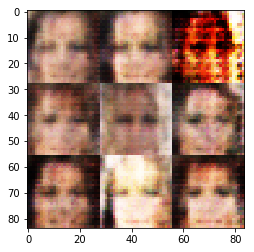

Epoch 1/1...  D loss: 1.3150  G loss: 0.8934
Epoch 1/1...  D loss: 1.3048  G loss: 0.9282
Epoch 1/1...  D loss: 1.2787  G loss: 0.7671
Epoch 1/1...  D loss: 1.3181  G loss: 0.8130
Epoch 1/1...  D loss: 1.3678  G loss: 0.8412
Epoch 1/1...  D loss: 1.2786  G loss: 1.2321
Epoch 1/1...  D loss: 1.3280  G loss: 0.7785
Epoch 1/1...  D loss: 1.2509  G loss: 0.9740
Epoch 1/1...  D loss: 1.2046  G loss: 0.7878
Epoch 1/1...  D loss: 1.2462  G loss: 0.8611


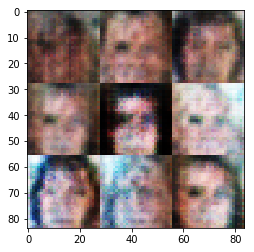

Epoch 1/1...  D loss: 1.1774  G loss: 0.6555
Epoch 1/1...  D loss: 1.2841  G loss: 0.9381
Epoch 1/1...  D loss: 1.2411  G loss: 0.7958
Epoch 1/1...  D loss: 1.3224  G loss: 0.8518
Epoch 1/1...  D loss: 1.3327  G loss: 0.8017
Epoch 1/1...  D loss: 1.3380  G loss: 0.8722
Epoch 1/1...  D loss: 1.2702  G loss: 0.8805
Epoch 1/1...  D loss: 1.3245  G loss: 0.9910
Epoch 1/1...  D loss: 1.3174  G loss: 0.8287
Epoch 1/1...  D loss: 0.8933  G loss: 1.9373


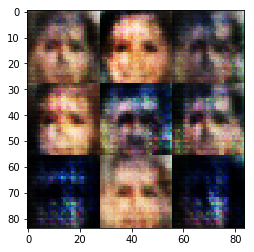

Epoch 1/1...  D loss: 1.3262  G loss: 0.8719
Epoch 1/1...  D loss: 1.2730  G loss: 0.8497
Epoch 1/1...  D loss: 1.3069  G loss: 0.8128
Epoch 1/1...  D loss: 1.3063  G loss: 0.8370
Epoch 1/1...  D loss: 1.2934  G loss: 0.8601
Epoch 1/1...  D loss: 1.3238  G loss: 0.8110
Epoch 1/1...  D loss: 1.2927  G loss: 0.7989
Epoch 1/1...  D loss: 1.3050  G loss: 0.7624
Epoch 1/1...  D loss: 1.3046  G loss: 0.8144
Epoch 1/1...  D loss: 1.3147  G loss: 0.8871


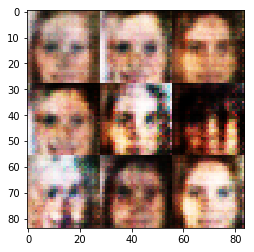

Epoch 1/1...  D loss: 1.2894  G loss: 0.7427
Epoch 1/1...  D loss: 1.3027  G loss: 0.7259
Epoch 1/1...  D loss: 1.3157  G loss: 0.8157
Epoch 1/1...  D loss: 1.3205  G loss: 0.7766
Epoch 1/1...  D loss: 1.2849  G loss: 0.7938
Epoch 1/1...  D loss: 1.2762  G loss: 0.8064
Epoch 1/1...  D loss: 1.2510  G loss: 0.8831
Epoch 1/1...  D loss: 1.3245  G loss: 0.8082
Epoch 1/1...  D loss: 1.3475  G loss: 0.7872
Epoch 1/1...  D loss: 1.3515  G loss: 0.8475


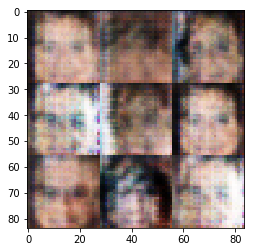

Epoch 1/1...  D loss: 1.2986  G loss: 0.7811
Epoch 1/1...  D loss: 1.3350  G loss: 0.8612
Epoch 1/1...  D loss: 1.3346  G loss: 0.8126
Epoch 1/1...  D loss: 1.3747  G loss: 0.7801
Epoch 1/1...  D loss: 1.3179  G loss: 0.8713
Epoch 1/1...  D loss: 1.2579  G loss: 0.7926
Epoch 1/1...  D loss: 1.2498  G loss: 0.8138
Epoch 1/1...  D loss: 1.3019  G loss: 0.6876
Epoch 1/1...  D loss: 1.2763  G loss: 0.8573
Epoch 1/1...  D loss: 1.2657  G loss: 0.9572


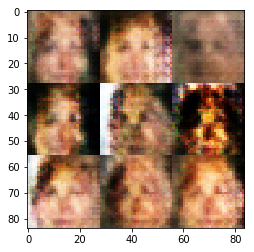

Epoch 1/1...  D loss: 1.3141  G loss: 0.8514
Epoch 1/1...  D loss: 1.2710  G loss: 0.8232
Epoch 1/1...  D loss: 1.3310  G loss: 0.8006
Epoch 1/1...  D loss: 1.3324  G loss: 0.9401
Epoch 1/1...  D loss: 1.2672  G loss: 0.8875
Epoch 1/1...  D loss: 1.0438  G loss: 1.2096
Epoch 1/1...  D loss: 1.2764  G loss: 0.7199
Epoch 1/1...  D loss: 1.2034  G loss: 0.8238
Epoch 1/1...  D loss: 1.1617  G loss: 1.1530
Epoch 1/1...  D loss: 1.2575  G loss: 0.8752


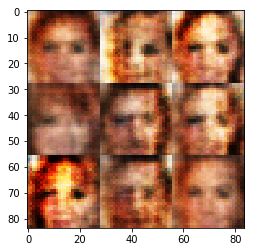

Epoch 1/1...  D loss: 1.1142  G loss: 1.0280
Epoch 1/1...  D loss: 1.2422  G loss: 0.8689
Epoch 1/1...  D loss: 1.2209  G loss: 0.8113
Epoch 1/1...  D loss: 1.2936  G loss: 0.8364
Epoch 1/1...  D loss: 1.2899  G loss: 1.0166
Epoch 1/1...  D loss: 1.2619  G loss: 0.9209
Epoch 1/1...  D loss: 1.2529  G loss: 0.8394
Epoch 1/1...  D loss: 1.3598  G loss: 1.2426
Epoch 1/1...  D loss: 1.2615  G loss: 0.8648
Epoch 1/1...  D loss: 1.2318  G loss: 1.0477


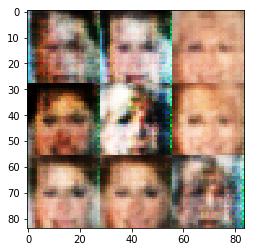

Epoch 1/1...  D loss: 1.2312  G loss: 0.7545
Epoch 1/1...  D loss: 1.2826  G loss: 0.8482
Epoch 1/1...  D loss: 1.2011  G loss: 0.9224
Epoch 1/1...  D loss: 1.2362  G loss: 0.8904
Epoch 1/1...  D loss: 1.2149  G loss: 1.0111
Epoch 1/1...  D loss: 1.2546  G loss: 0.8416
Epoch 1/1...  D loss: 1.2687  G loss: 0.8966
Epoch 1/1...  D loss: 1.2770  G loss: 0.8388
Epoch 1/1...  D loss: 1.3204  G loss: 0.7913
Epoch 1/1...  D loss: 1.2009  G loss: 0.9030


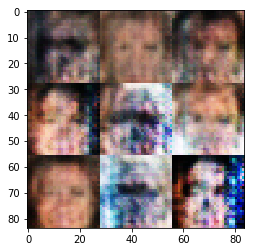

Epoch 1/1...  D loss: 1.1113  G loss: 0.8468
Epoch 1/1...  D loss: 1.2489  G loss: 0.8919
Epoch 1/1...  D loss: 1.2204  G loss: 0.9511
Epoch 1/1...  D loss: 1.2547  G loss: 0.8187
Epoch 1/1...  D loss: 1.2964  G loss: 0.8760
Epoch 1/1...  D loss: 1.2446  G loss: 0.9079
Epoch 1/1...  D loss: 1.3082  G loss: 0.8311
Epoch 1/1...  D loss: 1.2132  G loss: 1.1767
Epoch 1/1...  D loss: 1.2353  G loss: 0.8440
Epoch 1/1...  D loss: 1.2399  G loss: 0.8196


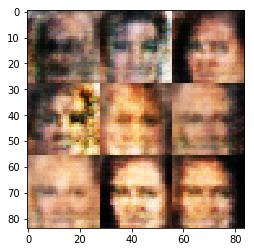

Epoch 1/1...  D loss: 1.2409  G loss: 0.9022
Epoch 1/1...  D loss: 1.2723  G loss: 0.8527
Epoch 1/1...  D loss: 1.2353  G loss: 0.7873
Epoch 1/1...  D loss: 1.1788  G loss: 0.8877
Epoch 1/1...  D loss: 1.2327  G loss: 0.9443
Epoch 1/1...  D loss: 1.2108  G loss: 0.8745
Epoch 1/1...  D loss: 1.2756  G loss: 1.1010
Epoch 1/1...  D loss: 1.2925  G loss: 0.8525
Epoch 1/1...  D loss: 1.2064  G loss: 0.9196
Epoch 1/1...  D loss: 0.9220  G loss: 1.0746


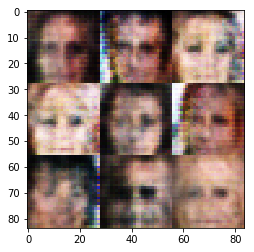

Epoch 1/1...  D loss: 1.2349  G loss: 0.8458
Epoch 1/1...  D loss: 1.2467  G loss: 0.8143
Epoch 1/1...  D loss: 1.2421  G loss: 0.9118
Epoch 1/1...  D loss: 1.2141  G loss: 0.9394
Epoch 1/1...  D loss: 1.2875  G loss: 0.8930
Epoch 1/1...  D loss: 1.2453  G loss: 0.8233
Epoch 1/1...  D loss: 1.2551  G loss: 0.8664
Epoch 1/1...  D loss: 1.3283  G loss: 0.8321
Epoch 1/1...  D loss: 1.2331  G loss: 0.8573
Epoch 1/1...  D loss: 1.2561  G loss: 0.8439


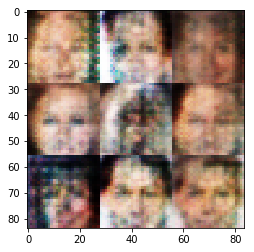

Epoch 1/1...  D loss: 1.1730  G loss: 0.8460
Epoch 1/1...  D loss: 1.2715  G loss: 0.7937
Epoch 1/1...  D loss: 1.1308  G loss: 1.0033
Epoch 1/1...  D loss: 1.1898  G loss: 0.9369
Epoch 1/1...  D loss: 1.2261  G loss: 0.7732
Epoch 1/1...  D loss: 1.2343  G loss: 0.8016
Epoch 1/1...  D loss: 0.9054  G loss: 1.0668
Epoch 1/1...  D loss: 1.2933  G loss: 0.8115
Epoch 1/1...  D loss: 1.2701  G loss: 0.8715
Epoch 1/1...  D loss: 1.1219  G loss: 1.0905


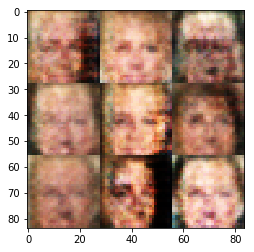

Epoch 1/1...  D loss: 1.2621  G loss: 0.8045
Epoch 1/1...  D loss: 1.2661  G loss: 0.8615
Epoch 1/1...  D loss: 1.2737  G loss: 0.8235
Epoch 1/1...  D loss: 1.2461  G loss: 0.8937
Epoch 1/1...  D loss: 1.2461  G loss: 0.9414
Epoch 1/1...  D loss: 1.2236  G loss: 0.8420
Epoch 1/1...  D loss: 1.2638  G loss: 0.7744
Epoch 1/1...  D loss: 1.2592  G loss: 0.9115
Epoch 1/1...  D loss: 1.3154  G loss: 0.8828
Epoch 1/1...  D loss: 1.2808  G loss: 0.9175


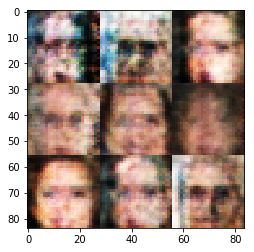

Epoch 1/1...  D loss: 1.2551  G loss: 0.8080
Epoch 1/1...  D loss: 1.2945  G loss: 0.8177
Epoch 1/1...  D loss: 1.1809  G loss: 0.8736
Epoch 1/1...  D loss: 1.1891  G loss: 0.9031
Epoch 1/1...  D loss: 1.0364  G loss: 0.8282
Epoch 1/1...  D loss: 1.1060  G loss: 0.9596
Epoch 1/1...  D loss: 1.2972  G loss: 0.7993
Epoch 1/1...  D loss: 1.2371  G loss: 0.7824
Epoch 1/1...  D loss: 1.2319  G loss: 0.7995
Epoch 1/1...  D loss: 1.3212  G loss: 0.8432


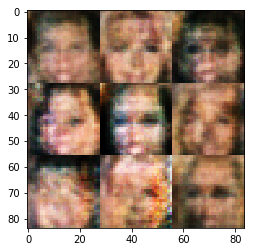

Epoch 1/1...  D loss: 1.2576  G loss: 0.8300
Epoch 1/1...  D loss: 1.1684  G loss: 1.0765
Epoch 1/1...  D loss: 1.3319  G loss: 0.7632
Epoch 1/1...  D loss: 1.3062  G loss: 0.8277
Epoch 1/1...  D loss: 1.1954  G loss: 0.9350
Epoch 1/1...  D loss: 1.1754  G loss: 0.9714
Epoch 1/1...  D loss: 1.2078  G loss: 0.8998
Epoch 1/1...  D loss: 1.2107  G loss: 0.8369
Epoch 1/1...  D loss: 1.2356  G loss: 0.7962
Epoch 1/1...  D loss: 1.0528  G loss: 0.7718


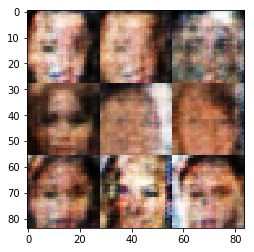

Epoch 1/1...  D loss: 1.1792  G loss: 1.0658
Epoch 1/1...  D loss: 1.2259  G loss: 0.8485
Epoch 1/1...  D loss: 1.2792  G loss: 0.8436
Epoch 1/1...  D loss: 1.2299  G loss: 0.8212
Epoch 1/1...  D loss: 1.2371  G loss: 0.8575
Epoch 1/1...  D loss: 1.2837  G loss: 0.8486
Epoch 1/1...  D loss: 1.2976  G loss: 0.8499
Epoch 1/1...  D loss: 1.2297  G loss: 0.8104
Epoch 1/1...  D loss: 1.2674  G loss: 0.8418
Epoch 1/1...  D loss: 1.2671  G loss: 0.8521


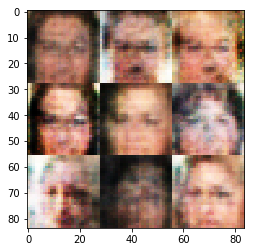

Epoch 1/1...  D loss: 1.2018  G loss: 0.8992
Epoch 1/1...  D loss: 1.2560  G loss: 0.8623
Epoch 1/1...  D loss: 1.2024  G loss: 0.9623
Epoch 1/1...  D loss: 1.2916  G loss: 0.8577
Epoch 1/1...  D loss: 1.2773  G loss: 0.9072
Epoch 1/1...  D loss: 1.2935  G loss: 0.8787
Epoch 1/1...  D loss: 1.2825  G loss: 0.8989
Epoch 1/1...  D loss: 1.2823  G loss: 0.8214
Epoch 1/1...  D loss: 1.2669  G loss: 0.7537
Epoch 1/1...  D loss: 0.9743  G loss: 0.9872


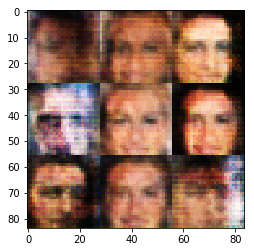

Epoch 1/1...  D loss: 1.2607  G loss: 0.7905
Epoch 1/1...  D loss: 1.2249  G loss: 0.9269
Epoch 1/1...  D loss: 1.2756  G loss: 0.8202
Epoch 1/1...  D loss: 1.2572  G loss: 0.9045
Epoch 1/1...  D loss: 1.2777  G loss: 0.8578
Epoch 1/1...  D loss: 1.2610  G loss: 0.7917
Epoch 1/1...  D loss: 1.2706  G loss: 0.7810
Epoch 1/1...  D loss: 1.2952  G loss: 0.7791
Epoch 1/1...  D loss: 1.2376  G loss: 0.8789
Epoch 1/1...  D loss: 1.2579  G loss: 0.9189


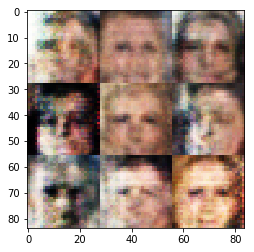

Epoch 1/1...  D loss: 1.2651  G loss: 0.8688
Epoch 1/1...  D loss: 1.2160  G loss: 0.9594
Epoch 1/1...  D loss: 1.2580  G loss: 0.8160
Epoch 1/1...  D loss: 1.2505  G loss: 0.9558
Epoch 1/1...  D loss: 1.2714  G loss: 0.8509
Epoch 1/1...  D loss: 1.2927  G loss: 0.8397
Epoch 1/1...  D loss: 1.3159  G loss: 0.8686
Epoch 1/1...  D loss: 1.2813  G loss: 0.8132
Epoch 1/1...  D loss: 1.2993  G loss: 0.8958
Epoch 1/1...  D loss: 1.3055  G loss: 0.9637


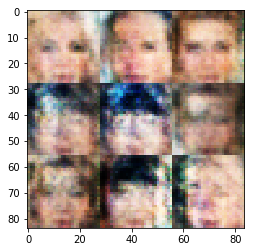

Epoch 1/1...  D loss: 1.3266  G loss: 0.7631
Epoch 1/1...  D loss: 1.2935  G loss: 0.9047
Epoch 1/1...  D loss: 1.3302  G loss: 0.8768
Epoch 1/1...  D loss: 1.3378  G loss: 0.7526
Epoch 1/1...  D loss: 1.3012  G loss: 0.8785
Epoch 1/1...  D loss: 1.2790  G loss: 0.7985
Epoch 1/1...  D loss: 1.2640  G loss: 0.8681
Epoch 1/1...  D loss: 1.3087  G loss: 0.7996
Epoch 1/1...  D loss: 1.3152  G loss: 0.8404
Epoch 1/1...  D loss: 1.3262  G loss: 0.8402


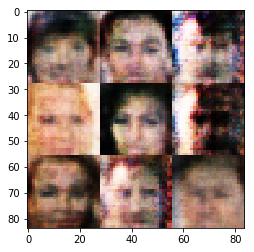

Epoch 1/1...  D loss: 1.3152  G loss: 0.8671
Epoch 1/1...  D loss: 1.2082  G loss: 0.8341
Epoch 1/1...  D loss: 1.2371  G loss: 0.7838
Epoch 1/1...  D loss: 1.2370  G loss: 0.7978
Epoch 1/1...  D loss: 1.2787  G loss: 0.8253
Epoch 1/1...  D loss: 1.2942  G loss: 0.7955
Epoch 1/1...  D loss: 1.2735  G loss: 0.8922
Epoch 1/1...  D loss: 1.2647  G loss: 0.7942
Epoch 1/1...  D loss: 1.2926  G loss: 0.8522
Epoch 1/1...  D loss: 1.2591  G loss: 0.8322


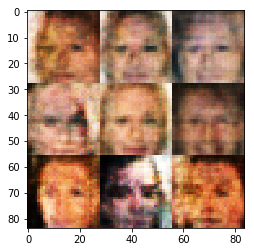

Epoch 1/1...  D loss: 1.2522  G loss: 0.7935
Epoch 1/1...  D loss: 1.3306  G loss: 0.8161
Epoch 1/1...  D loss: 1.3275  G loss: 0.7379
Epoch 1/1...  D loss: 1.2818  G loss: 0.8288
Epoch 1/1...  D loss: 1.2722  G loss: 0.8331
Epoch 1/1...  D loss: 1.2866  G loss: 0.9055
Epoch 1/1...  D loss: 1.3204  G loss: 0.8583
Epoch 1/1...  D loss: 1.2659  G loss: 0.7682
Epoch 1/1...  D loss: 1.2611  G loss: 0.9162
Epoch 1/1...  D loss: 1.2875  G loss: 0.9569


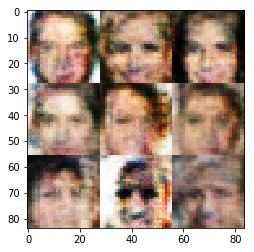

Epoch 1/1...  D loss: 1.2496  G loss: 0.8253
Epoch 1/1...  D loss: 1.2200  G loss: 0.8295
Epoch 1/1...  D loss: 1.2502  G loss: 0.7657
Epoch 1/1...  D loss: 1.1821  G loss: 0.9608
Epoch 1/1...  D loss: 1.3302  G loss: 0.6043
Epoch 1/1...  D loss: 1.2839  G loss: 0.7548
Epoch 1/1...  D loss: 1.3016  G loss: 0.8655
Epoch 1/1...  D loss: 1.3250  G loss: 0.8337
Epoch 1/1...  D loss: 1.2774  G loss: 0.7568
Epoch 1/1...  D loss: 1.2438  G loss: 0.8828


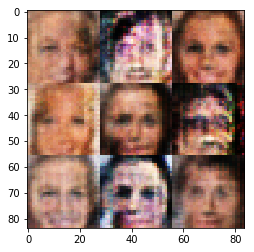

Epoch 1/1...  D loss: 1.2980  G loss: 0.8817
Epoch 1/1...  D loss: 1.2714  G loss: 0.7558
Epoch 1/1...  D loss: 1.2763  G loss: 0.8114
Epoch 1/1...  D loss: 1.2038  G loss: 0.9554
Epoch 1/1...  D loss: 1.1360  G loss: 0.8066
Epoch 1/1...  D loss: 1.3136  G loss: 0.8413
Epoch 1/1...  D loss: 1.2290  G loss: 0.9080
Epoch 1/1...  D loss: 1.2663  G loss: 0.8816
Epoch 1/1...  D loss: 1.2514  G loss: 1.0120
Epoch 1/1...  D loss: 1.2328  G loss: 0.9464


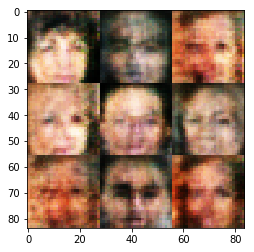

Epoch 1/1...  D loss: 1.2990  G loss: 0.7262
Epoch 1/1...  D loss: 1.2708  G loss: 0.8182
Epoch 1/1...  D loss: 1.2237  G loss: 0.8256
Epoch 1/1...  D loss: 1.2524  G loss: 0.9519
Epoch 1/1...  D loss: 1.2852  G loss: 0.8712
Epoch 1/1...  D loss: 1.2699  G loss: 0.7977
Epoch 1/1...  D loss: 1.2791  G loss: 0.8715
Epoch 1/1...  D loss: 1.2642  G loss: 0.7988
Epoch 1/1...  D loss: 1.2086  G loss: 0.9686
Epoch 1/1...  D loss: 1.2514  G loss: 0.8053


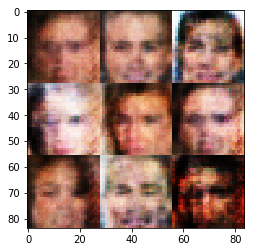

Epoch 1/1...  D loss: 1.0401  G loss: 0.9307
Epoch 1/1...  D loss: 1.3047  G loss: 0.7026
Epoch 1/1...  D loss: 1.2352  G loss: 0.8546
Epoch 1/1...  D loss: 1.2345  G loss: 0.9176
Epoch 1/1...  D loss: 1.2762  G loss: 0.7791
Epoch 1/1...  D loss: 1.2407  G loss: 0.8953
Epoch 1/1...  D loss: 1.2069  G loss: 0.8548
Epoch 1/1...  D loss: 1.1954  G loss: 0.9195
Epoch 1/1...  D loss: 1.2361  G loss: 0.9318
Epoch 1/1...  D loss: 1.2232  G loss: 0.9744


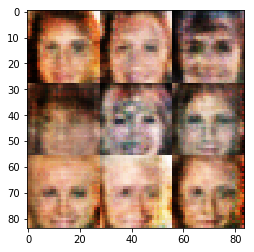

Epoch 1/1...  D loss: 1.2400  G loss: 0.8509
Epoch 1/1...  D loss: 1.2419  G loss: 0.8851
Epoch 1/1...  D loss: 1.2555  G loss: 0.8857
Epoch 1/1...  D loss: 1.2575  G loss: 0.8005
Epoch 1/1...  D loss: 1.2034  G loss: 0.9124
Epoch 1/1...  D loss: 1.2465  G loss: 0.9894
Epoch 1/1...  D loss: 1.2385  G loss: 0.9260
Epoch 1/1...  D loss: 1.2733  G loss: 0.8533
Epoch 1/1...  D loss: 1.2854  G loss: 0.8514
Epoch 1/1...  D loss: 1.2479  G loss: 0.8257


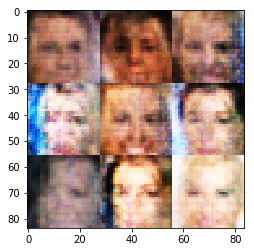

Epoch 1/1...  D loss: 1.1859  G loss: 0.8925
Epoch 1/1...  D loss: 1.2703  G loss: 0.9657
Epoch 1/1...  D loss: 1.1982  G loss: 0.8713
Epoch 1/1...  D loss: 1.2493  G loss: 0.8201
Epoch 1/1...  D loss: 1.3075  G loss: 0.8427
Epoch 1/1...  D loss: 1.2553  G loss: 0.8438
Epoch 1/1...  D loss: 1.2532  G loss: 0.8406
Epoch 1/1...  D loss: 1.2623  G loss: 0.9216
Epoch 1/1...  D loss: 1.2805  G loss: 0.8472
Epoch 1/1...  D loss: 1.2449  G loss: 0.8187


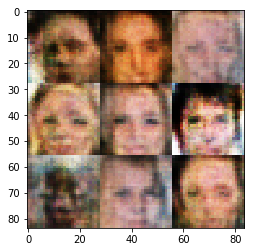

Epoch 1/1...  D loss: 1.2396  G loss: 0.8610
Epoch 1/1...  D loss: 1.7695  G loss: 1.8798
Epoch 1/1...  D loss: 1.2884  G loss: 0.8089
Epoch 1/1...  D loss: 1.3103  G loss: 0.8250
Epoch 1/1...  D loss: 1.2685  G loss: 0.7690
Epoch 1/1...  D loss: 1.2801  G loss: 0.8284
Epoch 1/1...  D loss: 1.2245  G loss: 0.9098
Epoch 1/1...  D loss: 1.2045  G loss: 0.9006
Epoch 1/1...  D loss: 1.2849  G loss: 0.8034
Epoch 1/1...  D loss: 1.2941  G loss: 0.8123


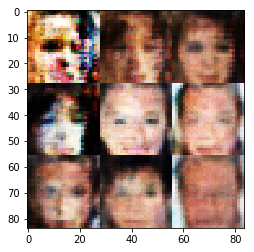

Epoch 1/1...  D loss: 1.2854  G loss: 0.9091
Epoch 1/1...  D loss: 1.2351  G loss: 0.8760
Epoch 1/1...  D loss: 1.1956  G loss: 1.0186
Epoch 1/1...  D loss: 1.2555  G loss: 0.8656
Epoch 1/1...  D loss: 1.2916  G loss: 0.8512
Epoch 1/1...  D loss: 1.2608  G loss: 0.8248
Epoch 1/1...  D loss: 1.2732  G loss: 0.9210
Epoch 1/1...  D loss: 1.3021  G loss: 0.8602
Epoch 1/1...  D loss: 1.2647  G loss: 0.8551
Epoch 1/1...  D loss: 1.3049  G loss: 0.7732


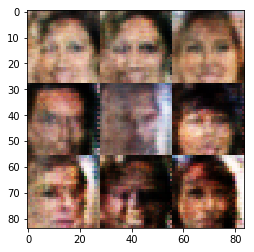

Epoch 1/1...  D loss: 1.3029  G loss: 0.8737
Epoch 1/1...  D loss: 1.2677  G loss: 0.8074
Epoch 1/1...  D loss: 0.8207  G loss: 0.9929
Epoch 1/1...  D loss: 1.2879  G loss: 0.8423
Epoch 1/1...  D loss: 1.3120  G loss: 0.8551
Epoch 1/1...  D loss: 1.2534  G loss: 0.8556
Epoch 1/1...  D loss: 1.2832  G loss: 0.9332
Epoch 1/1...  D loss: 1.3027  G loss: 0.8647
Epoch 1/1...  D loss: 1.2857  G loss: 0.8302
Epoch 1/1...  D loss: 1.2502  G loss: 0.8272


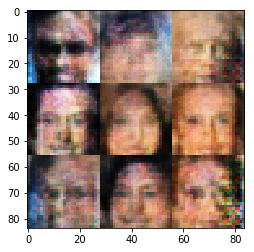

Epoch 1/1...  D loss: 1.2758  G loss: 0.9409
Epoch 1/1...  D loss: 1.2758  G loss: 0.8535
Epoch 1/1...  D loss: 1.2879  G loss: 0.8457
Epoch 1/1...  D loss: 1.2629  G loss: 0.8027
Epoch 1/1...  D loss: 1.2435  G loss: 0.8800
Epoch 1/1...  D loss: 1.2914  G loss: 0.8367
Epoch 1/1...  D loss: 1.2250  G loss: 0.8776
Epoch 1/1...  D loss: 1.2836  G loss: 0.8552
Epoch 1/1...  D loss: 1.2519  G loss: 0.8779
Epoch 1/1...  D loss: 1.2453  G loss: 0.8890


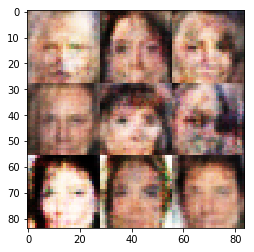

Epoch 1/1...  D loss: 1.2617  G loss: 0.9344
Epoch 1/1...  D loss: 1.2878  G loss: 0.8655
Epoch 1/1...  D loss: 1.2617  G loss: 0.8547
Epoch 1/1...  D loss: 1.3208  G loss: 0.8751
Epoch 1/1...  D loss: 1.2819  G loss: 0.7900
Epoch 1/1...  D loss: 1.2784  G loss: 0.8491
Epoch 1/1...  D loss: 1.2565  G loss: 0.8320
Epoch 1/1...  D loss: 1.2612  G loss: 0.8679
Epoch 1/1...  D loss: 1.2301  G loss: 0.8213
Epoch 1/1...  D loss: 1.2909  G loss: 0.9785


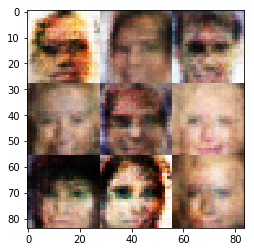

Epoch 1/1...  D loss: 1.1969  G loss: 0.8752
Epoch 1/1...  D loss: 1.2204  G loss: 0.8888
Epoch 1/1...  D loss: 1.2926  G loss: 0.8900
Epoch 1/1...  D loss: 1.2528  G loss: 0.8832
Epoch 1/1...  D loss: 1.2418  G loss: 0.8818
Epoch 1/1...  D loss: 1.2812  G loss: 0.8605
Epoch 1/1...  D loss: 1.2622  G loss: 0.8729
Epoch 1/1...  D loss: 1.2321  G loss: 0.8783
Epoch 1/1...  D loss: 1.2841  G loss: 0.8963
Epoch 1/1...  D loss: 1.2984  G loss: 0.8777


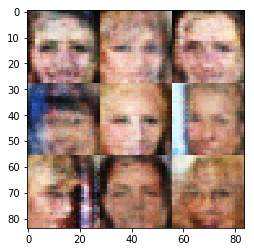

Epoch 1/1...  D loss: 1.3078  G loss: 0.7947
Epoch 1/1...  D loss: 1.2668  G loss: 0.8484
Epoch 1/1...  D loss: 1.2156  G loss: 0.8363
Epoch 1/1...  D loss: 1.2695  G loss: 0.8419
Epoch 1/1...  D loss: 1.2478  G loss: 0.9306
Epoch 1/1...  D loss: 1.2995  G loss: 0.8031
Epoch 1/1...  D loss: 1.2481  G loss: 0.8464
Epoch 1/1...  D loss: 1.2436  G loss: 0.8678
Epoch 1/1...  D loss: 1.2456  G loss: 0.8540
Epoch 1/1...  D loss: 1.2673  G loss: 0.9282


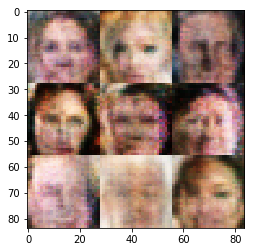

Epoch 1/1...  D loss: 1.2239  G loss: 0.7936
Epoch 1/1...  D loss: 1.2699  G loss: 0.8752
Epoch 1/1...  D loss: 1.2371  G loss: 0.8347
Epoch 1/1...  D loss: 1.2586  G loss: 0.8567
Epoch 1/1...  D loss: 1.2438  G loss: 0.7597
Epoch 1/1...  D loss: 1.2603  G loss: 0.8765
Epoch 1/1...  D loss: 1.2661  G loss: 0.7618
Epoch 1/1...  D loss: 1.2673  G loss: 0.8962
Epoch 1/1...  D loss: 1.2867  G loss: 0.7436
Epoch 1/1...  D loss: 1.1497  G loss: 0.7135


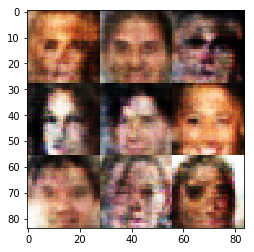

Epoch 1/1...  D loss: 1.2597  G loss: 1.1077
Epoch 1/1...  D loss: 1.2595  G loss: 0.8588
Epoch 1/1...  D loss: 1.1982  G loss: 1.0429
Epoch 1/1...  D loss: 1.1493  G loss: 0.8596
Epoch 1/1...  D loss: 1.2612  G loss: 0.8556
Epoch 1/1...  D loss: 1.2656  G loss: 0.8363
Epoch 1/1...  D loss: 1.9040  G loss: 2.1472
Epoch 1/1...  D loss: 1.2602  G loss: 0.8658
Epoch 1/1...  D loss: 1.2480  G loss: 0.9065
Epoch 1/1...  D loss: 1.3000  G loss: 0.8233


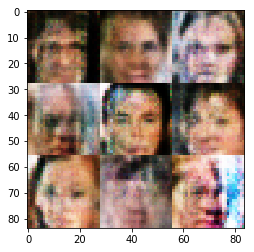

Epoch 1/1...  D loss: 1.2939  G loss: 0.8601
Epoch 1/1...  D loss: 1.2147  G loss: 0.8692
Epoch 1/1...  D loss: 1.2152  G loss: 0.8628
Epoch 1/1...  D loss: 1.2564  G loss: 0.8264
Epoch 1/1...  D loss: 1.2717  G loss: 0.8568
Epoch 1/1...  D loss: 1.2639  G loss: 0.8387
Epoch 1/1...  D loss: 1.2228  G loss: 0.8922
Epoch 1/1...  D loss: 1.1968  G loss: 0.9150
Epoch 1/1...  D loss: 1.1990  G loss: 0.8419
Epoch 1/1...  D loss: 1.2365  G loss: 0.9104


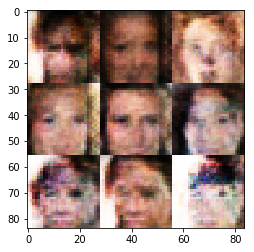

Epoch 1/1...  D loss: 1.2659  G loss: 0.9176
Epoch 1/1...  D loss: 1.2361  G loss: 0.8903
Epoch 1/1...  D loss: 0.8156  G loss: 1.0483
Epoch 1/1...  D loss: 1.3043  G loss: 0.8041
Epoch 1/1...  D loss: 1.2368  G loss: 0.9112
Epoch 1/1...  D loss: 1.2623  G loss: 0.8510
Epoch 1/1...  D loss: 1.2470  G loss: 0.8431
Epoch 1/1...  D loss: 1.3122  G loss: 0.8072
Epoch 1/1...  D loss: 1.2404  G loss: 0.8809
Epoch 1/1...  D loss: 1.2357  G loss: 0.8671


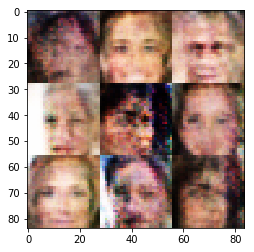

Epoch 1/1...  D loss: 1.2480  G loss: 0.8980
Epoch 1/1...  D loss: 1.2634  G loss: 0.8890
Epoch 1/1...  D loss: 1.2263  G loss: 0.8307
Epoch 1/1...  D loss: 1.2257  G loss: 0.8849
Epoch 1/1...  D loss: 1.2774  G loss: 0.8546
Epoch 1/1...  D loss: 1.2285  G loss: 0.9077
Epoch 1/1...  D loss: 1.2633  G loss: 0.9216
Epoch 1/1...  D loss: 1.2094  G loss: 0.8988
Epoch 1/1...  D loss: 1.2304  G loss: 0.9406
Epoch 1/1...  D loss: 1.2876  G loss: 1.0030


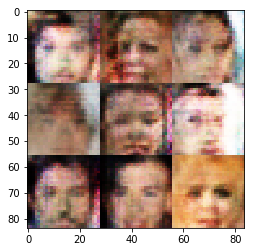

Epoch 1/1...  D loss: 1.2520  G loss: 0.8257
Epoch 1/1...  D loss: 1.2861  G loss: 0.8297
Epoch 1/1...  D loss: 1.2536  G loss: 0.8734
Epoch 1/1...  D loss: 1.2796  G loss: 0.8033
Epoch 1/1...  D loss: 1.2113  G loss: 0.9122
Epoch 1/1...  D loss: 1.2262  G loss: 0.8821
Epoch 1/1...  D loss: 1.2463  G loss: 0.8505
Epoch 1/1...  D loss: 1.2360  G loss: 0.8821
Epoch 1/1...  D loss: 1.0105  G loss: 0.8036
Epoch 1/1...  D loss: 1.1918  G loss: 1.0147


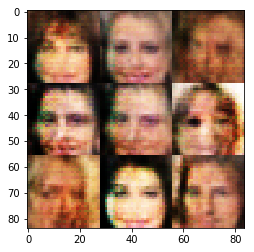

Epoch 1/1...  D loss: 1.1546  G loss: 0.9015
Epoch 1/1...  D loss: 1.1922  G loss: 0.8320
Epoch 1/1...  D loss: 1.2013  G loss: 0.8640
Epoch 1/1...  D loss: 1.2081  G loss: 0.9118
Epoch 1/1...  D loss: 1.2576  G loss: 0.8636
Epoch 1/1...  D loss: 1.2548  G loss: 0.8824
Epoch 1/1...  D loss: 1.2267  G loss: 0.8342
Epoch 1/1...  D loss: 1.2216  G loss: 0.8834
Epoch 1/1...  D loss: 1.2122  G loss: 0.9249
Epoch 1/1...  D loss: 1.2378  G loss: 0.8096


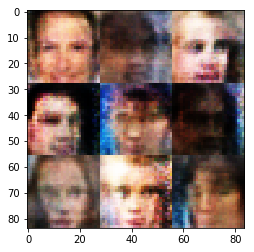

Epoch 1/1...  D loss: 1.2444  G loss: 0.8778
Epoch 1/1...  D loss: 1.2105  G loss: 0.8509
Epoch 1/1...  D loss: 1.1973  G loss: 0.8729
Epoch 1/1...  D loss: 1.2536  G loss: 0.8803
Epoch 1/1...  D loss: 1.2805  G loss: 0.8392
Epoch 1/1...  D loss: 1.2259  G loss: 0.9350
Epoch 1/1...  D loss: 1.2651  G loss: 0.8428
Epoch 1/1...  D loss: 1.2482  G loss: 0.8593
Epoch 1/1...  D loss: 1.1632  G loss: 0.9075
Epoch 1/1...  D loss: 1.2717  G loss: 0.8524


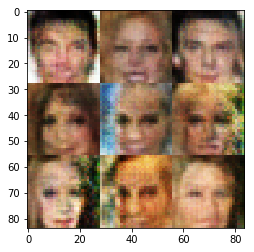

Epoch 1/1...  D loss: 1.2548  G loss: 0.8634
Epoch 1/1...  D loss: 1.2689  G loss: 0.8040
Epoch 1/1...  D loss: 1.2615  G loss: 0.8135
Epoch 1/1...  D loss: 1.2426  G loss: 0.8643
Epoch 1/1...  D loss: 1.2531  G loss: 0.8193
Epoch 1/1...  D loss: 1.3212  G loss: 0.8668
Epoch 1/1...  D loss: 1.2320  G loss: 0.8897
Epoch 1/1...  D loss: 1.3340  G loss: 1.3919
Epoch 1/1...  D loss: 0.8491  G loss: 0.9049
Epoch 1/1...  D loss: 0.3811  G loss: 2.7835


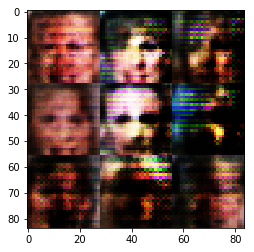

Epoch 1/1...  D loss: 0.6663  G loss: 1.8036
Epoch 1/1...  D loss: 1.1306  G loss: 1.3315
Epoch 1/1...  D loss: 0.8652  G loss: 1.2350
Epoch 1/1...  D loss: 1.0940  G loss: 0.9425
Epoch 1/1...  D loss: 1.1434  G loss: 0.8489
Epoch 1/1...  D loss: 1.1212  G loss: 1.0435
Epoch 1/1...  D loss: 1.0334  G loss: 1.0879
Epoch 1/1...  D loss: 1.1806  G loss: 0.7463
Epoch 1/1...  D loss: 1.1699  G loss: 0.9363
Epoch 1/1...  D loss: 1.1077  G loss: 1.0603


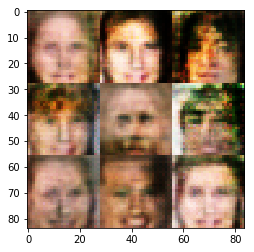

Epoch 1/1...  D loss: 1.1257  G loss: 1.0448
Epoch 1/1...  D loss: 1.1555  G loss: 0.9080
Epoch 1/1...  D loss: 1.0730  G loss: 1.0164
Epoch 1/1...  D loss: 1.2155  G loss: 0.8490
Epoch 1/1...  D loss: 1.2039  G loss: 1.0950
Epoch 1/1...  D loss: 1.1787  G loss: 0.8679
Epoch 1/1...  D loss: 1.1769  G loss: 0.9284
Epoch 1/1...  D loss: 1.1599  G loss: 0.9661
Epoch 1/1...  D loss: 1.1753  G loss: 0.8374
Epoch 1/1...  D loss: 1.1181  G loss: 1.0346


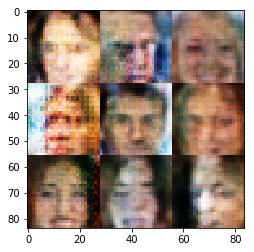

Epoch 1/1...  D loss: 1.2463  G loss: 0.8446
Epoch 1/1...  D loss: 1.1955  G loss: 0.9611
Epoch 1/1...  D loss: 1.1590  G loss: 0.9664
Epoch 1/1...  D loss: 1.1828  G loss: 0.9223
Epoch 1/1...  D loss: 1.1989  G loss: 0.8504
Epoch 1/1...  D loss: 1.1217  G loss: 1.0245
Epoch 1/1...  D loss: 1.1761  G loss: 0.8441
Epoch 1/1...  D loss: 1.1434  G loss: 0.9051
Epoch 1/1...  D loss: 1.1271  G loss: 0.9346
Epoch 1/1...  D loss: 1.1307  G loss: 0.9060


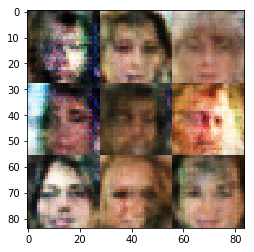

Epoch 1/1...  D loss: 1.1846  G loss: 0.9045
Epoch 1/1...  D loss: 1.1254  G loss: 1.0809
Epoch 1/1...  D loss: 1.1217  G loss: 0.8229
Epoch 1/1...  D loss: 1.1181  G loss: 0.9751
Epoch 1/1...  D loss: 1.1294  G loss: 0.9119
Epoch 1/1...  D loss: 1.1759  G loss: 0.9165
Epoch 1/1...  D loss: 1.1705  G loss: 0.8417
Epoch 1/1...  D loss: 1.6850  G loss: 1.5710
Epoch 1/1...  D loss: 1.1667  G loss: 0.9297
Epoch 1/1...  D loss: 1.2384  G loss: 0.8826


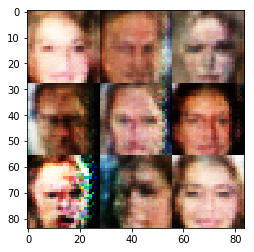

Epoch 1/1...  D loss: 1.1563  G loss: 0.9586
Epoch 1/1...  D loss: 1.1957  G loss: 0.9399
Epoch 1/1...  D loss: 1.1274  G loss: 0.9639
Epoch 1/1...  D loss: 1.2284  G loss: 0.8743
Epoch 1/1...  D loss: 1.1607  G loss: 1.0070
Epoch 1/1...  D loss: 1.2128  G loss: 0.8835
Epoch 1/1...  D loss: 1.1908  G loss: 0.9708
Epoch 1/1...  D loss: 1.1190  G loss: 1.0059
Epoch 1/1...  D loss: 1.1841  G loss: 0.9274
Epoch 1/1...  D loss: 1.2223  G loss: 0.8824


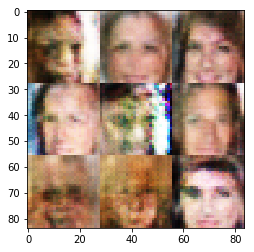

Epoch 1/1...  D loss: 1.1779  G loss: 0.9434
Epoch 1/1...  D loss: 1.1828  G loss: 0.9106
Epoch 1/1...  D loss: 1.2407  G loss: 0.8617
Epoch 1/1...  D loss: 1.2373  G loss: 0.8753
Epoch 1/1...  D loss: 1.1713  G loss: 0.9573
Epoch 1/1...  D loss: 1.1851  G loss: 0.8617
Epoch 1/1...  D loss: 1.1810  G loss: 0.9257
Epoch 1/1...  D loss: 1.2200  G loss: 0.9520
Epoch 1/1...  D loss: 1.1936  G loss: 0.8649
Epoch 1/1...  D loss: 1.2125  G loss: 0.8718


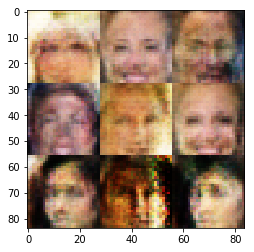

Epoch 1/1...  D loss: 0.9053  G loss: 1.3734
Epoch 1/1...  D loss: 1.1332  G loss: 1.2082
Epoch 1/1...  D loss: 1.2986  G loss: 2.9049
Epoch 1/1...  D loss: 0.4464  G loss: 2.0935
Epoch 1/1...  D loss: 1.1835  G loss: 0.9533
Epoch 1/1...  D loss: 1.1062  G loss: 1.1286
Epoch 1/1...  D loss: 1.0563  G loss: 1.0511
Epoch 1/1...  D loss: 1.0775  G loss: 1.0221
Epoch 1/1...  D loss: 1.1091  G loss: 1.0093
Epoch 1/1...  D loss: 1.0867  G loss: 1.0148


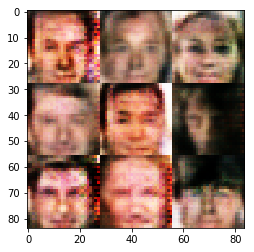

Epoch 1/1...  D loss: 1.1167  G loss: 0.8801
Epoch 1/1...  D loss: 0.9940  G loss: 1.0855
Epoch 1/1...  D loss: 1.1712  G loss: 1.6079
Epoch 1/1...  D loss: 1.1069  G loss: 1.1477
Epoch 1/1...  D loss: 0.9535  G loss: 1.0069
Epoch 1/1...  D loss: 1.0890  G loss: 1.1757
Epoch 1/1...  D loss: 0.8853  G loss: 1.4210
Epoch 1/1...  D loss: 0.8778  G loss: 0.9614
Epoch 1/1...  D loss: 1.1975  G loss: 0.9219
Epoch 1/1...  D loss: 1.0785  G loss: 1.0125


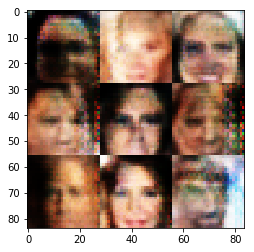

Epoch 1/1...  D loss: 0.7703  G loss: 1.3267
Epoch 1/1...  D loss: 1.2544  G loss: 0.5980
Epoch 1/1...  D loss: 0.8758  G loss: 1.1351
Epoch 1/1...  D loss: 0.9886  G loss: 2.3154
Epoch 1/1...  D loss: 0.6373  G loss: 2.7365
Epoch 1/1...  D loss: 0.6623  G loss: 1.2934
Epoch 1/1...  D loss: 0.4382  G loss: 2.2662
Epoch 1/1...  D loss: 0.4297  G loss: 2.3785
Epoch 1/1...  D loss: 1.0862  G loss: 1.2798
Epoch 1/1...  D loss: 0.8329  G loss: 2.2610


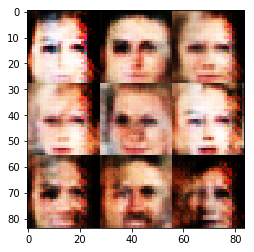

Epoch 1/1...  D loss: 0.3490  G loss: 3.6349
Epoch 1/1...  D loss: 0.8243  G loss: 1.4192
Epoch 1/1...  D loss: 0.9443  G loss: 1.2276
Epoch 1/1...  D loss: 0.8408  G loss: 1.2553
Epoch 1/1...  D loss: 0.8350  G loss: 1.3166
Epoch 1/1...  D loss: 0.7135  G loss: 1.2221
Epoch 1/1...  D loss: 0.6123  G loss: 1.7265
Epoch 1/1...  D loss: 0.5436  G loss: 1.6036
Epoch 1/1...  D loss: 0.5188  G loss: 1.8720
Epoch 1/1...  D loss: 0.6884  G loss: 2.5156


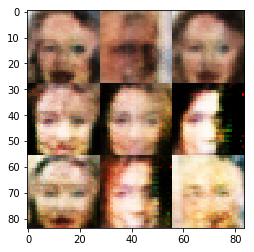

Epoch 1/1...  D loss: 0.4139  G loss: 2.3247
Epoch 1/1...  D loss: 2.1157  G loss: 2.5887
Epoch 1/1...  D loss: 1.3559  G loss: 3.1538
Epoch 1/1...  D loss: 1.0248  G loss: 2.3260
Epoch 1/1...  D loss: 0.7754  G loss: 2.0199
Epoch 1/1...  D loss: 1.6857  G loss: 2.8371
Epoch 1/1...  D loss: 0.5074  G loss: 1.8734
Epoch 1/1...  D loss: 0.3856  G loss: 2.9517
Epoch 1/1...  D loss: 0.8163  G loss: 2.2586
Epoch 1/1...  D loss: 0.5632  G loss: 1.7458


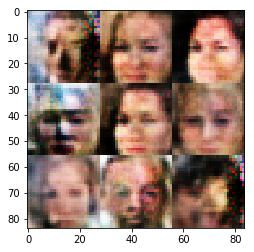

Epoch 1/1...  D loss: 0.3901  G loss: 2.6791
Epoch 1/1...  D loss: 0.5156  G loss: 1.7170
Epoch 1/1...  D loss: 0.3964  G loss: 2.9134
Epoch 1/1...  D loss: 0.4100  G loss: 2.4855
Epoch 1/1...  D loss: 0.9286  G loss: 1.0978
Epoch 1/1...  D loss: 0.8577  G loss: 1.1543
Epoch 1/1...  D loss: 0.7173  G loss: 1.6581
Epoch 1/1...  D loss: 0.4347  G loss: 2.3101
Epoch 1/1...  D loss: 1.0411  G loss: 0.9688
Epoch 1/1...  D loss: 0.7628  G loss: 1.4394


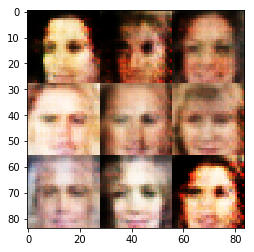

Epoch 1/1...  D loss: 0.9707  G loss: 2.2356
Epoch 1/1...  D loss: 0.5040  G loss: 1.8097
Epoch 1/1...  D loss: 0.5002  G loss: 2.6812
Epoch 1/1...  D loss: 0.4115  G loss: 2.3710
Epoch 1/1...  D loss: 0.6503  G loss: 2.5089
Epoch 1/1...  D loss: 0.8286  G loss: 2.0040
Epoch 1/1...  D loss: 0.5913  G loss: 1.4878
Epoch 1/1...  D loss: 0.4310  G loss: 2.2431
Epoch 1/1...  D loss: 0.6982  G loss: 1.4569
Epoch 1/1...  D loss: 0.4683  G loss: 2.1555


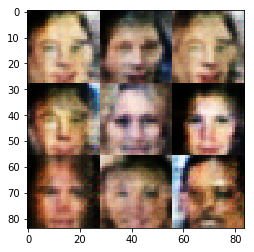

Epoch 1/1...  D loss: 0.4184  G loss: 2.3290
Epoch 1/1...  D loss: 0.4636  G loss: 1.9581
Epoch 1/1...  D loss: 0.4439  G loss: 2.1361
Epoch 1/1...  D loss: 0.5781  G loss: 1.7687
Epoch 1/1...  D loss: 1.5711  G loss: 3.5848
Epoch 1/1...  D loss: 0.4708  G loss: 2.2950
Epoch 1/1...  D loss: 0.4411  G loss: 2.3324
Epoch 1/1...  D loss: 0.7406  G loss: 3.1148
Epoch 1/1...  D loss: 0.6979  G loss: 1.1403
Epoch 1/1...  D loss: 0.5136  G loss: 2.1317


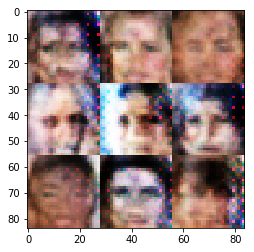

Epoch 1/1...  D loss: 0.5799  G loss: 2.2764
Epoch 1/1...  D loss: 0.8217  G loss: 1.4552
Epoch 1/1...  D loss: 0.4740  G loss: 2.2470
Epoch 1/1...  D loss: 0.3964  G loss: 2.6410
Epoch 1/1...  D loss: 0.7563  G loss: 1.7480
Epoch 1/1...  D loss: 0.7192  G loss: 1.8506
Epoch 1/1...  D loss: 0.6132  G loss: 1.6401
Epoch 1/1...  D loss: 0.6895  G loss: 2.3266
Epoch 1/1...  D loss: 0.5098  G loss: 1.9646
Epoch 1/1...  D loss: 0.3752  G loss: 3.1565


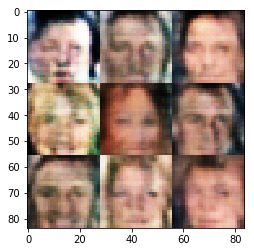

Epoch 1/1...  D loss: 0.7195  G loss: 1.2512
Epoch 1/1...  D loss: 0.5171  G loss: 1.7747
Epoch 1/1...  D loss: 0.8256  G loss: 2.8600
Epoch 1/1...  D loss: 0.5208  G loss: 2.0200
Epoch 1/1...  D loss: 1.6289  G loss: 3.4137
Epoch 1/1...  D loss: 1.1516  G loss: 2.7287
Epoch 1/1...  D loss: 0.5319  G loss: 3.1383
Epoch 1/1...  D loss: 0.8920  G loss: 1.2388
Epoch 1/1...  D loss: 0.9105  G loss: 1.2798
Epoch 1/1...  D loss: 0.5144  G loss: 1.9928


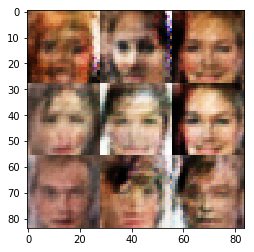

Epoch 1/1...  D loss: 0.5140  G loss: 2.0371
Epoch 1/1...  D loss: 0.4272  G loss: 2.2751
Epoch 1/1...  D loss: 0.8205  G loss: 2.7371
Epoch 1/1...  D loss: 0.4660  G loss: 2.0248
Epoch 1/1...  D loss: 0.6206  G loss: 1.4165
Epoch 1/1...  D loss: 0.5198  G loss: 2.7870
Epoch 1/1...  D loss: 0.5098  G loss: 1.7797
Epoch 1/1...  D loss: 0.4830  G loss: 2.1389
Epoch 1/1...  D loss: 0.9410  G loss: 1.0023
Epoch 1/1...  D loss: 0.3942  G loss: 2.6191


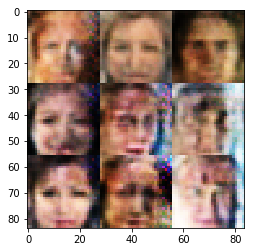

Epoch 1/1...  D loss: 0.4344  G loss: 2.1901
Epoch 1/1...  D loss: 1.2863  G loss: 0.5851
Epoch 1/1...  D loss: 0.7275  G loss: 2.8467
Epoch 1/1...  D loss: 0.3961  G loss: 2.7046
Epoch 1/1...  D loss: 2.3250  G loss: 3.4839
Epoch 1/1...  D loss: 0.3903  G loss: 2.6967
Epoch 1/1...  D loss: 0.4786  G loss: 2.7578
Epoch 1/1...  D loss: 0.3825  G loss: 2.7676
Epoch 1/1...  D loss: 1.2738  G loss: 1.0571
Epoch 1/1...  D loss: 0.9222  G loss: 1.3689


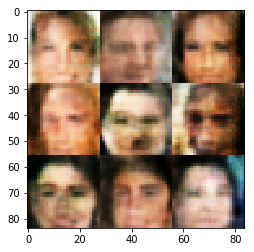

Epoch 1/1...  D loss: 1.1439  G loss: 0.9616
Epoch 1/1...  D loss: 0.9337  G loss: 1.3666
Epoch 1/1...  D loss: 0.7412  G loss: 1.4160
Epoch 1/1...  D loss: 0.6949  G loss: 1.5357
Epoch 1/1...  D loss: 0.7092  G loss: 1.9919
Epoch 1/1...  D loss: 0.7763  G loss: 2.2754
Epoch 1/1...  D loss: 0.6575  G loss: 2.0310
Epoch 1/1...  D loss: 0.6480  G loss: 1.6379
Epoch 1/1...  D loss: 0.6939  G loss: 1.6218
Epoch 1/1...  D loss: 0.7468  G loss: 1.3716


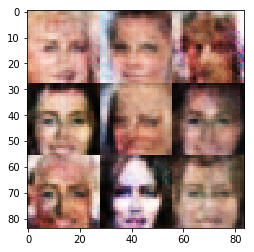

Epoch 1/1...  D loss: 0.5945  G loss: 2.1069
Epoch 1/1...  D loss: 0.7464  G loss: 1.3314
Epoch 1/1...  D loss: 0.6305  G loss: 1.7931
Epoch 1/1...  D loss: 0.9728  G loss: 2.7957
Epoch 1/1...  D loss: 0.6553  G loss: 2.0155
Epoch 1/1...  D loss: 0.6384  G loss: 1.7490
Epoch 1/1...  D loss: 0.5708  G loss: 2.2010
Epoch 1/1...  D loss: 0.6868  G loss: 1.8672
Epoch 1/1...  D loss: 0.5982  G loss: 1.5943
Epoch 1/1...  D loss: 0.6341  G loss: 1.7403


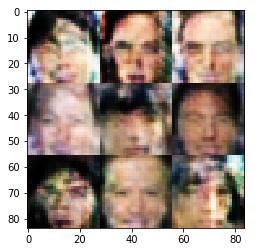

Epoch 1/1...  D loss: 0.8162  G loss: 2.3572
Epoch 1/1...  D loss: 0.7078  G loss: 2.0384
Epoch 1/1...  D loss: 0.6677  G loss: 2.1875
Epoch 1/1...  D loss: 0.7234  G loss: 1.2724
Epoch 1/1...  D loss: 0.6680  G loss: 1.3176
Epoch 1/1...  D loss: 0.7504  G loss: 2.6887
Epoch 1/1...  D loss: 0.6337  G loss: 1.3889
Epoch 1/1...  D loss: 0.7480  G loss: 2.2374
Epoch 1/1...  D loss: 0.8572  G loss: 1.0969
Epoch 1/1...  D loss: 0.6593  G loss: 1.6182


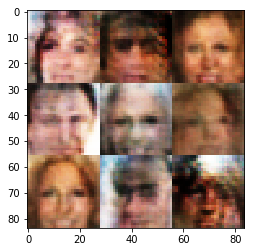

Epoch 1/1...  D loss: 0.6404  G loss: 1.5222
Epoch 1/1...  D loss: 0.7611  G loss: 1.4235
Epoch 1/1...  D loss: 0.7254  G loss: 1.5068
Epoch 1/1...  D loss: 0.6758  G loss: 1.5043
Epoch 1/1...  D loss: 0.6944  G loss: 1.5098
Epoch 1/1...  D loss: 0.7314  G loss: 1.9476
Epoch 1/1...  D loss: 0.7105  G loss: 1.8268
Epoch 1/1...  D loss: 0.7956  G loss: 1.2486
Epoch 1/1...  D loss: 0.7144  G loss: 1.7943
Epoch 1/1...  D loss: 0.7972  G loss: 1.3819


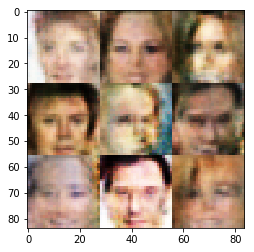

Epoch 1/1...  D loss: 0.7457  G loss: 1.1431
Epoch 1/1...  D loss: 0.8728  G loss: 2.8008
Epoch 1/1...  D loss: 0.7230  G loss: 1.4351
Epoch 1/1...  D loss: 0.7433  G loss: 1.2101
Epoch 1/1...  D loss: 0.7046  G loss: 1.6816
Epoch 1/1...  D loss: 0.6093  G loss: 1.9542
Epoch 1/1...  D loss: 1.0353  G loss: 2.5392
Epoch 1/1...  D loss: 0.4620  G loss: 2.1826
Epoch 1/1...  D loss: 0.5750  G loss: 1.7065
Epoch 1/1...  D loss: 0.6116  G loss: 1.3701


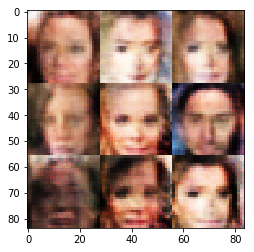

Epoch 1/1...  D loss: 1.5437  G loss: 2.8930
Epoch 1/1...  D loss: 0.6967  G loss: 1.1811
Epoch 1/1...  D loss: 0.4899  G loss: 1.8555
Epoch 1/1...  D loss: 0.5239  G loss: 2.3650
Epoch 1/1...  D loss: 0.9221  G loss: 1.3131
Epoch 1/1...  D loss: 0.8812  G loss: 1.0615
Epoch 1/1...  D loss: 0.9522  G loss: 1.2209
Epoch 1/1...  D loss: 0.8485  G loss: 1.8314
Epoch 1/1...  D loss: 0.8208  G loss: 1.3220
Epoch 1/1...  D loss: 0.7875  G loss: 1.5612


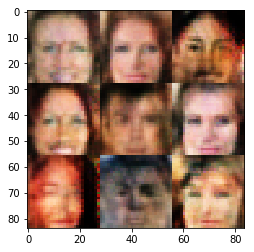

Epoch 1/1...  D loss: 0.7642  G loss: 1.4178
Epoch 1/1...  D loss: 0.8193  G loss: 1.1504
Epoch 1/1...  D loss: 0.7569  G loss: 1.2769
Epoch 1/1...  D loss: 0.7357  G loss: 1.5143
Epoch 1/1...  D loss: 0.6832  G loss: 1.7424
Epoch 1/1...  D loss: 0.7529  G loss: 1.2218
Epoch 1/1...  D loss: 0.6713  G loss: 1.4668
Epoch 1/1...  D loss: 0.7754  G loss: 2.3188
Epoch 1/1...  D loss: 0.7431  G loss: 1.7649
Epoch 1/1...  D loss: 0.7468  G loss: 1.2519


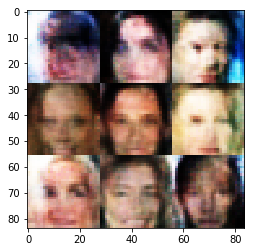

Epoch 1/1...  D loss: 0.7809  G loss: 1.6185
Epoch 1/1...  D loss: 1.1441  G loss: 0.6819
Epoch 1/1...  D loss: 0.7331  G loss: 1.2857
Epoch 1/1...  D loss: 0.7492  G loss: 1.5598
Epoch 1/1...  D loss: 0.7638  G loss: 2.0321
Epoch 1/1...  D loss: 0.7591  G loss: 1.4282
Epoch 1/1...  D loss: 0.7540  G loss: 1.4361
Epoch 1/1...  D loss: 0.7803  G loss: 1.5110
Epoch 1/1...  D loss: 1.0994  G loss: 0.7190
Epoch 1/1...  D loss: 0.6725  G loss: 1.4714


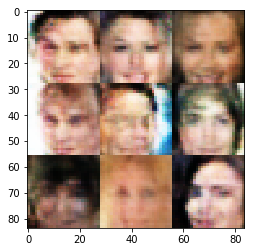

Epoch 1/1...  D loss: 0.8439  G loss: 1.0544
Epoch 1/1...  D loss: 0.8254  G loss: 1.2197
Epoch 1/1...  D loss: 0.8003  G loss: 1.7693
Epoch 1/1...  D loss: 0.6851  G loss: 1.5232
Epoch 1/1...  D loss: 0.7182  G loss: 1.6717
Epoch 1/1...  D loss: 0.8223  G loss: 1.3510
Epoch 1/1...  D loss: 0.6789  G loss: 1.7032
Epoch 1/1...  D loss: 0.6995  G loss: 1.7202
Epoch 1/1...  D loss: 0.7712  G loss: 1.4760
Epoch 1/1...  D loss: 0.8490  G loss: 2.1304


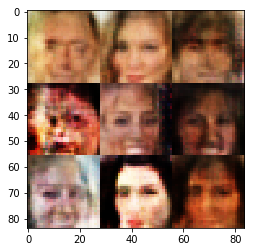

Epoch 1/1...  D loss: 0.8551  G loss: 1.0016
Epoch 1/1...  D loss: 0.8161  G loss: 1.1975
Epoch 1/1...  D loss: 0.8884  G loss: 0.9831
Epoch 1/1...  D loss: 0.8555  G loss: 1.3000
Epoch 1/1...  D loss: 0.8143  G loss: 1.1289
Epoch 1/1...  D loss: 0.7656  G loss: 1.3465
Epoch 1/1...  D loss: 0.8079  G loss: 1.0723
Epoch 1/1...  D loss: 0.8024  G loss: 1.3163
Epoch 1/1...  D loss: 0.7924  G loss: 1.5085
Epoch 1/1...  D loss: 0.9058  G loss: 1.0419


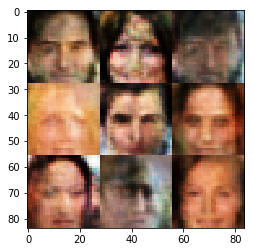

Epoch 1/1...  D loss: 0.9077  G loss: 1.1140
Epoch 1/1...  D loss: 0.8414  G loss: 1.2679
Epoch 1/1...  D loss: 0.7871  G loss: 1.4305
Epoch 1/1...  D loss: 0.7255  G loss: 1.4427
Epoch 1/1...  D loss: 0.8512  G loss: 1.2687
Epoch 1/1...  D loss: 0.8081  G loss: 1.1674
Epoch 1/1...  D loss: 0.8418  G loss: 1.0510
Epoch 1/1...  D loss: 0.8331  G loss: 1.8638
Epoch 1/1...  D loss: 0.7531  G loss: 1.3939
Epoch 1/1...  D loss: 0.8132  G loss: 1.7974


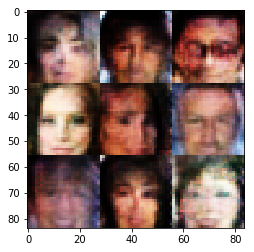

Epoch 1/1...  D loss: 0.8187  G loss: 1.1432
Epoch 1/1...  D loss: 0.7852  G loss: 1.1914
Epoch 1/1...  D loss: 0.7451  G loss: 1.3476
Epoch 1/1...  D loss: 0.7830  G loss: 1.7959
Epoch 1/1...  D loss: 0.5541  G loss: 1.6677
Epoch 1/1...  D loss: 0.6441  G loss: 1.5004
Epoch 1/1...  D loss: 0.4355  G loss: 2.3544
Epoch 1/1...  D loss: 0.4555  G loss: 2.1248
Epoch 1/1...  D loss: 1.3139  G loss: 3.0649
Epoch 1/1...  D loss: 0.4171  G loss: 2.3488


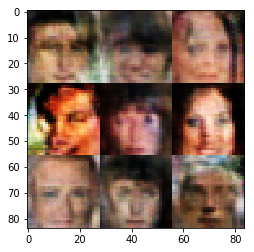

Epoch 1/1...  D loss: 0.4191  G loss: 2.6306
Epoch 1/1...  D loss: 0.4007  G loss: 2.9404
Epoch 1/1...  D loss: 0.3988  G loss: 2.7386
Epoch 1/1...  D loss: 0.9479  G loss: 2.4899
Epoch 1/1...  D loss: 0.3947  G loss: 2.7391
Epoch 1/1...  D loss: 0.9757  G loss: 0.8352
Epoch 1/1...  D loss: 0.7935  G loss: 1.6736
Epoch 1/1...  D loss: 0.7608  G loss: 1.2599
Epoch 1/1...  D loss: 0.7525  G loss: 1.7987
Epoch 1/1...  D loss: 0.7262  G loss: 1.5722


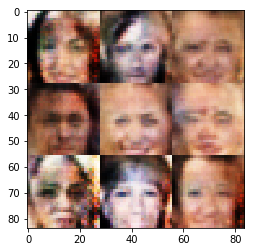

Epoch 1/1...  D loss: 0.7945  G loss: 1.5030
Epoch 1/1...  D loss: 0.6613  G loss: 1.5046
Epoch 1/1...  D loss: 0.7558  G loss: 1.2910
Epoch 1/1...  D loss: 0.6742  G loss: 1.5395
Epoch 1/1...  D loss: 0.7127  G loss: 1.6512
Epoch 1/1...  D loss: 0.6818  G loss: 1.4023
Epoch 1/1...  D loss: 0.6856  G loss: 1.3692
Epoch 1/1...  D loss: 0.6855  G loss: 1.6187
Epoch 1/1...  D loss: 0.7882  G loss: 1.3034
Epoch 1/1...  D loss: 0.6839  G loss: 1.4875


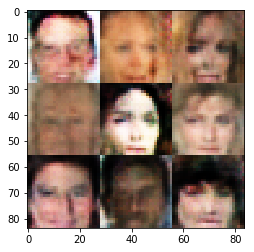

Epoch 1/1...  D loss: 0.7733  G loss: 1.3860
Epoch 1/1...  D loss: 0.7213  G loss: 1.8482
Epoch 1/1...  D loss: 0.7428  G loss: 1.4752
Epoch 1/1...  D loss: 0.9908  G loss: 2.3884
Epoch 1/1...  D loss: 0.7666  G loss: 1.5106
Epoch 1/1...  D loss: 0.8106  G loss: 1.1600
Epoch 1/1...  D loss: 0.7967  G loss: 1.3881
Epoch 1/1...  D loss: 0.7363  G loss: 1.2260
Epoch 1/1...  D loss: 0.7507  G loss: 1.2189
Epoch 1/1...  D loss: 0.8118  G loss: 1.1106


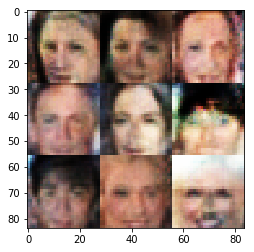

Epoch 1/1...  D loss: 0.7857  G loss: 1.4492
Epoch 1/1...  D loss: 0.6698  G loss: 1.4339
Epoch 1/1...  D loss: 0.8314  G loss: 1.1329
Epoch 1/1...  D loss: 0.8745  G loss: 1.0755
Epoch 1/1...  D loss: 0.7280  G loss: 1.5157
Epoch 1/1...  D loss: 0.7206  G loss: 1.7459
Epoch 1/1...  D loss: 0.7691  G loss: 1.3472
Epoch 1/1...  D loss: 0.8651  G loss: 1.9031
Epoch 1/1...  D loss: 0.8058  G loss: 1.2355
Epoch 1/1...  D loss: 0.8068  G loss: 1.2709


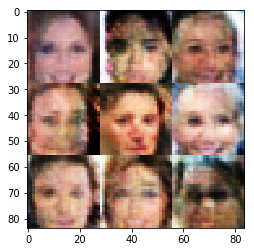

Epoch 1/1...  D loss: 0.9158  G loss: 0.9917
Epoch 1/1...  D loss: 0.8378  G loss: 2.0034
Epoch 1/1...  D loss: 0.7990  G loss: 1.4582
Epoch 1/1...  D loss: 0.7526  G loss: 1.3913
Epoch 1/1...  D loss: 0.9225  G loss: 1.3349
Epoch 1/1...  D loss: 0.8889  G loss: 1.0229
Epoch 1/1...  D loss: 0.7772  G loss: 1.7425
Epoch 1/1...  D loss: 0.7297  G loss: 1.6962
Epoch 1/1...  D loss: 0.7903  G loss: 1.4391
Epoch 1/1...  D loss: 0.7438  G loss: 1.4907


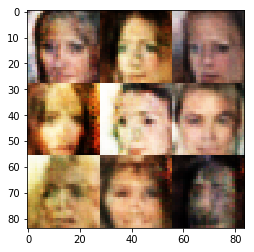

Epoch 1/1...  D loss: 0.6824  G loss: 1.2593
Epoch 1/1...  D loss: 0.7002  G loss: 1.5323
Epoch 1/1...  D loss: 0.9091  G loss: 1.8319
Epoch 1/1...  D loss: 0.7607  G loss: 1.2732
Epoch 1/1...  D loss: 1.1585  G loss: 1.8939
Epoch 1/1...  D loss: 0.7696  G loss: 1.5819
Epoch 1/1...  D loss: 0.6907  G loss: 1.6514
Epoch 1/1...  D loss: 0.7469  G loss: 1.4174
Epoch 1/1...  D loss: 1.0513  G loss: 2.4225
Epoch 1/1...  D loss: 0.4886  G loss: 1.8631


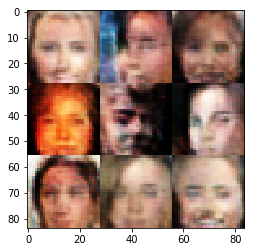

Epoch 1/1...  D loss: 0.7909  G loss: 1.5703
Epoch 1/1...  D loss: 0.8268  G loss: 1.1689
Epoch 1/1...  D loss: 0.6310  G loss: 1.8589
Epoch 1/1...  D loss: 0.7365  G loss: 1.2860
Epoch 1/1...  D loss: 0.7725  G loss: 2.3495
Epoch 1/1...  D loss: 0.4545  G loss: 2.1518
Epoch 1/1...  D loss: 0.4432  G loss: 2.3400
Epoch 1/1...  D loss: 1.0021  G loss: 1.3162
Epoch 1/1...  D loss: 0.7626  G loss: 1.7507
Epoch 1/1...  D loss: 0.7653  G loss: 1.6169


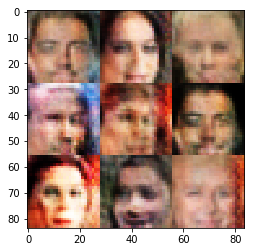

Epoch 1/1...  D loss: 0.6853  G loss: 1.5644
Epoch 1/1...  D loss: 0.9082  G loss: 1.4493
Epoch 1/1...  D loss: 0.9061  G loss: 1.0358
Epoch 1/1...  D loss: 0.8139  G loss: 1.2113
Epoch 1/1...  D loss: 0.7172  G loss: 1.7013
Epoch 1/1...  D loss: 0.7042  G loss: 1.7155
Epoch 1/1...  D loss: 0.8972  G loss: 1.1673
Epoch 1/1...  D loss: 0.8379  G loss: 1.5227
Epoch 1/1...  D loss: 0.7122  G loss: 1.2012
Epoch 1/1...  D loss: 0.7367  G loss: 1.2946


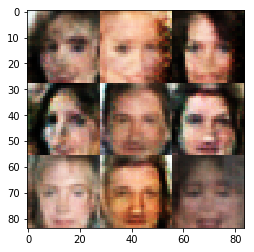

Epoch 1/1...  D loss: 0.7052  G loss: 1.1610
Epoch 1/1...  D loss: 0.4467  G loss: 2.0497
Epoch 1/1...  D loss: 0.6456  G loss: 1.5554
Epoch 1/1...  D loss: 0.3759  G loss: 3.1511
Epoch 1/1...  D loss: 1.7259  G loss: 0.4949
Epoch 1/1...  D loss: 0.8755  G loss: 2.1102
Epoch 1/1...  D loss: 0.9298  G loss: 1.6543
Epoch 1/1...  D loss: 0.5740  G loss: 1.5494
Epoch 1/1...  D loss: 0.7900  G loss: 1.5689
Epoch 1/1...  D loss: 0.6793  G loss: 1.7132


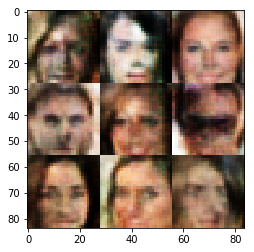

Epoch 1/1...  D loss: 0.9321  G loss: 2.2682
Epoch 1/1...  D loss: 0.7958  G loss: 1.1176
Epoch 1/1...  D loss: 0.5893  G loss: 1.5375
Epoch 1/1...  D loss: 0.4728  G loss: 2.1967
Epoch 1/1...  D loss: 1.3410  G loss: 0.6578
Epoch 1/1...  D loss: 0.4035  G loss: 2.5350
Epoch 1/1...  D loss: 0.8756  G loss: 1.0959
Epoch 1/1...  D loss: 0.9172  G loss: 1.3090
Epoch 1/1...  D loss: 0.9479  G loss: 1.1768
Epoch 1/1...  D loss: 0.8910  G loss: 1.2979


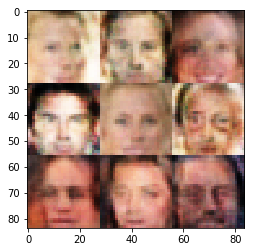

Epoch 1/1...  D loss: 0.9914  G loss: 1.2213
Epoch 1/1...  D loss: 0.8903  G loss: 1.3440
Epoch 1/1...  D loss: 0.7762  G loss: 1.6004
Epoch 1/1...  D loss: 0.8304  G loss: 1.2183
Epoch 1/1...  D loss: 0.9438  G loss: 1.1678
Epoch 1/1...  D loss: 0.8216  G loss: 1.4767
Epoch 1/1...  D loss: 0.8127  G loss: 1.3194
Epoch 1/1...  D loss: 0.8311  G loss: 1.4347
Epoch 1/1...  D loss: 0.7558  G loss: 1.4236
Epoch 1/1...  D loss: 0.7941  G loss: 1.3175


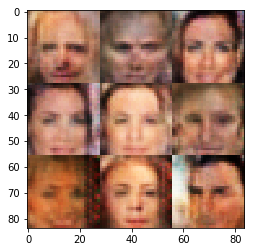

Epoch 1/1...  D loss: 0.8422  G loss: 1.4447
Epoch 1/1...  D loss: 0.7381  G loss: 1.4527
Epoch 1/1...  D loss: 0.8084  G loss: 1.3225
Epoch 1/1...  D loss: 0.8230  G loss: 1.6233
Epoch 1/1...  D loss: 0.7610  G loss: 1.8423
Epoch 1/1...  D loss: 0.8240  G loss: 1.1605
Epoch 1/1...  D loss: 0.7864  G loss: 1.5743
Epoch 1/1...  D loss: 0.8761  G loss: 0.9771
Epoch 1/1...  D loss: 0.7879  G loss: 1.4790
Epoch 1/1...  D loss: 0.9029  G loss: 1.0138


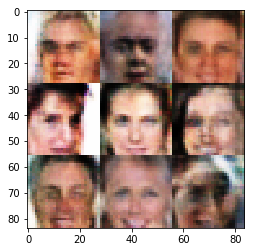

Epoch 1/1...  D loss: 0.8913  G loss: 1.1459
Epoch 1/1...  D loss: 0.8637  G loss: 1.4051
Epoch 1/1...  D loss: 0.8291  G loss: 1.3038
Epoch 1/1...  D loss: 0.7627  G loss: 1.7356
Epoch 1/1...  D loss: 0.9440  G loss: 1.1632
Epoch 1/1...  D loss: 0.8634  G loss: 1.0506
Epoch 1/1...  D loss: 0.8324  G loss: 1.2384
Epoch 1/1...  D loss: 0.8179  G loss: 1.3223
Epoch 1/1...  D loss: 0.8609  G loss: 1.5578
Epoch 1/1...  D loss: 0.9140  G loss: 1.5138


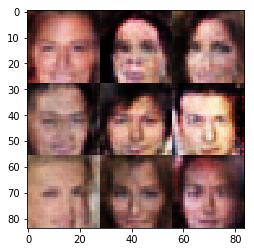

Epoch 1/1...  D loss: 0.8878  G loss: 1.0625
Epoch 1/1...  D loss: 0.7403  G loss: 1.6453
Epoch 1/1...  D loss: 0.8404  G loss: 1.2112
Epoch 1/1...  D loss: 0.8766  G loss: 1.1863
Epoch 1/1...  D loss: 0.8935  G loss: 1.7559
Epoch 1/1...  D loss: 0.8430  G loss: 1.2004
Epoch 1/1...  D loss: 0.9825  G loss: 1.0904
Epoch 1/1...  D loss: 0.9406  G loss: 1.0468
Epoch 1/1...  D loss: 1.0427  G loss: 0.9999
Epoch 1/1...  D loss: 0.9644  G loss: 0.9968


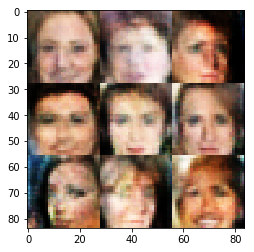

Epoch 1/1...  D loss: 0.6920  G loss: 1.5212
Epoch 1/1...  D loss: 0.7441  G loss: 1.3888
Epoch 1/1...  D loss: 0.9687  G loss: 1.0490
Epoch 1/1...  D loss: 0.8794  G loss: 1.0323
Epoch 1/1...  D loss: 0.8342  G loss: 1.2813
Epoch 1/1...  D loss: 0.8699  G loss: 1.2383
Epoch 1/1...  D loss: 0.8493  G loss: 1.4201
Epoch 1/1...  D loss: 0.8873  G loss: 1.1792
Epoch 1/1...  D loss: 0.8715  G loss: 1.4954
Epoch 1/1...  D loss: 0.9014  G loss: 1.1577


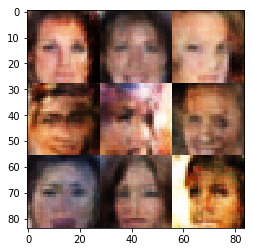

Epoch 1/1...  D loss: 0.8060  G loss: 1.2697
Epoch 1/1...  D loss: 0.8952  G loss: 1.2316
Epoch 1/1...  D loss: 0.7984  G loss: 1.4879
Epoch 1/1...  D loss: 0.9097  G loss: 1.0421
Epoch 1/1...  D loss: 0.8201  G loss: 1.2684
Epoch 1/1...  D loss: 0.7655  G loss: 1.3823
Epoch 1/1...  D loss: 0.8578  G loss: 1.3995
Epoch 1/1...  D loss: 0.9007  G loss: 1.4011
Epoch 1/1...  D loss: 0.9124  G loss: 1.1097
Epoch 1/1...  D loss: 0.7418  G loss: 1.4576


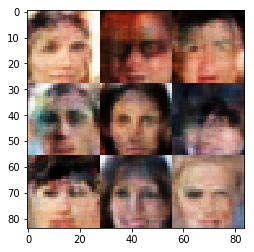

Epoch 1/1...  D loss: 0.8708  G loss: 1.3549
Epoch 1/1...  D loss: 0.8082  G loss: 1.3735
Epoch 1/1...  D loss: 0.8496  G loss: 1.2075
Epoch 1/1...  D loss: 0.9900  G loss: 1.0080
Epoch 1/1...  D loss: 0.8069  G loss: 1.2201
Epoch 1/1...  D loss: 0.7959  G loss: 1.3591


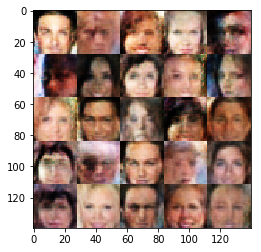

In [13]:
#batch_size = 200 # 1152
#z_dim = 100
#learning_rate = 0.001
#beta1 = 0.5

# AE: Continuing with the weights from MNIST section with the exception of batch_size.
# AE: These RGB pictures contain a lot more data than the black and white MNIST pictures,
# AE: and that's why using smaller batch size gives better results.
batch_size = 16
z_dim = 100
learning_rate = 0.0008
beta1 = 0.2
alpha=0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.